# Dependencies and files

## Install dependencies

## Imports

In [1]:
import warnings
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import os

import time
from tqdm.notebook import tqdm
import requests

sc.settings.set_figure_params(dpi=80)
#sc.set_figure_params(facecolor="white", figsize=(8, 8))
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 3

# Global variables

In [2]:
de_dir_path = '../../data/DE/ANOVA_mean/'

In [3]:
layers = ['L1', 'L2', 'L3', 'L4', 'L5', "L6", 'WM']

In [4]:
os.listdir(de_dir_path)

['anova_mamm_mean.csv',
 'cluster_spectr_anova_mean_6.csv',
 'cluster_spectr_anova_mean_7.csv',
 'cluster_spectr_anova_mean_8.csv',
 'cluster_spectr_anova_mean_9.csv',
 'ttest_mamm_mean.csv']

## Load files

### DE results

In [5]:
anova_res = pd.read_csv(de_dir_path + 'anova_mamm_mean.csv', index_col=0)
anova_genes = anova_res[anova_res.p_val_adj < 0.05].index
anova_res.head()

,sum_sq,df,F,PR(>F),p_val_adj
A1BG,0.122578,12.0,2.796490,0.003701,0.010364
AAAS,0.017527,12.0,0.944161,0.509517,0.596369
AACS,0.136394,12.0,2.729393,0.004508,0.012212
AADAT,0.057031,12.0,5.478881,0.000002,0.000016
AAGAB,0.043359,12.0,2.127609,0.026045,0.053640


In [6]:
n_clusters = 7
anova_labels = pd.read_csv(de_dir_path + f'cluster_spectr_anova_mean_{n_clusters}.csv', index_col=0)['0'].sort_values()
anova_labels = anova_labels
anova_labels.name = 'ANOVA_labels'

## Load normalized pseudobulks

In [7]:
pb_dir_path = 'results/'

In [8]:
os.listdir(pb_dir_path)

['.ipynb_checkpoints',
 'ancova_res.pkl',
 'chimp_clusters_28.csv',
 'chimp_clusters_50.csv',
 'chimp_clusters_77.csv',
 'gene_selection_df.csv',
 'hs_anova_inter_clusters.csv',
 'hs_layers.csv',
 'hs_prof.csv',
 'hs_prof_anova.csv',
 'hs_ttest_inter_clusters.csv',
 'human_clusters_28.csv',
 'human_clusters_50.csv',
 'human_clusters_67.csv',
 'human_clusters_77.csv',
 'human_clusters_ancova.csv',
 'hum_spec_onehot.csv',
 'l1_distances.pkl',
 'macaque_clusters_28.csv',
 'macaque_clusters_77.csv',
 'mean_norm_clust_allgenes.csv',
 'pb_mammals_samplenorm_mean_filtered.h5ad',
 'specie_specific_genes_tr28.pkl',
 'specie_specific_genes_tr35.pkl',
 'specie_specific_genes_tr50.pkl',
 'specie_specific_genes_tr67.pkl',
 'specie_specific_genes_tr77.pkl',
 'zscore_norm_clust_allgenes.csv']

In [9]:
adata_pb_norm = sc.read_h5ad(pb_dir_path + 'pb_mammals_samplenorm_mean_filtered.h5ad')
#adata_pb_norm_mean.var = anova_res
adata_pb_norm

AnnData object with n_obs × n_vars = 89 × 5390
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition', 'lib_size', 'log_lib_size'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props'

In [10]:
background_genes = adata_pb_norm.var_names.tolist()
len(background_genes)

5390

## Specie-specific genes

In [11]:
model_res = pd.read_csv('results/gene_selection_df.csv', index_col=0)
model_res.head()

,human,chimp,macaque
AACS,0.001206,0.014287,0.318736
AAGAB,0.731575,0.661344,0.024143
AAK1,0.000658,0.699175,0.069657
AAMP,0.762617,0.530339,0.947528
AAR2,0.312623,0.436571,0.343371


In [12]:
import pickle
with open("results/ancova_res.pkl", "rb") as file:
    ancova_results = pickle.load(file)

In [13]:
# import pickle
# with open("./results/specie_specific_genes_tr50.pkl", "rb") as file:
#     genes_dict77 = pickle.load(file)

In [14]:
sign_genes = {key:value[value['p-value'] < 0.05].index for key, value in ancova_results.items()}
sign_genes

{'human-chimp': Index(['ABCC10', 'ABCC5', 'ACBD6', 'ACSL1', 'ACTN2', 'ADORA1', 'AHNAK2', 'AK1',
        'AKAP7', 'AKT3',
        ...
        'WDR45', 'YWHAE', 'ZBTB17', 'ZBTB46', 'ZFP37', 'ZFPL1', 'ZMAT2',
        'ZMYND8', 'ZNF689', 'ZNF692'],
       dtype='object', length=400),
 'human-macaque': Index(['AAGAB', 'AAK1', 'AATF', 'AATK', 'ABAT', 'ABCC10', 'ABCD3', 'ABCD4',
        'ABTB1', 'ACAD9',
        ...
        'ZNF184', 'ZNF304', 'ZNF330', 'ZNF33A', 'ZNF408', 'ZNF575', 'ZNF576',
        'ZNF655', 'ZNF689', 'ZNF768'],
       dtype='object', length=1041),
 'chimp-macaque': Index(['AATK', 'ABAT', 'ABCD3', 'ABCD4', 'ABLIM3', 'ABTB1', 'ACAD9', 'ACOT13',
        'ACSBG1', 'ACSL1',
        ...
        'ZNF184', 'ZNF304', 'ZNF384', 'ZNF408', 'ZNF48', 'ZNF576', 'ZNF606',
        'ZNF655', 'ZNF689', 'ZNF768'],
       dtype='object', length=682)}

Попробуем определить человеко-специфичные гены как $(HC\bigcap HM)\setminus CM$

In [15]:
hs_genes = sign_genes['human-chimp'].intersection(sign_genes['human-macaque']).difference(sign_genes['chimp-macaque'])
hs_genes

Index(['ABCC10', 'ADORA1', 'AHNAK2', 'AKT3', 'ALCAM', 'ANXA6', 'APBB2',
       'ARHGAP12', 'ARL1', 'ASAH1', 'ATAD1', 'ATP1A3', 'ATP5F1E', 'BBOF1',
       'CABIN1', 'CDC23', 'CDK8', 'CERS5', 'COMMD6', 'DLGAP4', 'DMAP1',
       'EIF1B', 'EIF3L', 'EIF4E3', 'EIF4G3', 'ENC1', 'ERG28', 'ETHE1',
       'FAM32A', 'FBXW11', 'FGF9', 'FOXP1', 'FYN', 'GNPTAB', 'GTF3C2',
       'IGFBP2', 'IGFBP6', 'IGSF21', 'JAM2', 'KEAP1', 'KHDRBS3', 'KIF21B',
       'KLHDC8B', 'LIN7B', 'MAU2', 'MAX', 'MRPL50', 'NANS', 'NCAM2', 'NEK4',
       'NIM1K', 'NRXN1', 'NRXN2', 'OCIAD2', 'OTUD4', 'PCBP4', 'PCDH9', 'PDIA3',
       'PEPD', 'PHYHIP', 'PPP1CB', 'PPP1CC', 'PPP2R5A', 'PPP4C', 'PSME2',
       'PTPRK', 'RAB22A', 'RABEP1', 'RALYL', 'RND2', 'RNF40', 'RRM1', 'RRP9',
       'SCN3B', 'SCRG1', 'SF3B6', 'SLC6A6', 'SMG7', 'SND1', 'SNX15', 'STAU2',
       'SURF2', 'SYNGAP1', 'SYNPR', 'THY1', 'TMEM108', 'TMEM54', 'TMEM59L',
       'TTC8', 'VAT1L', 'VGLL4', 'VIPAS39', 'VPS51', 'YWHAE', 'ZBTB46',
       'ZMYND8'],
      dtype

Так мы далеко не уедем

## Helpful functions

In [16]:
def p_val_group(value):
    if value >= 0.05:
        return 'No significance'
    elif  0.01 <= value < 0.05:
        return 'p < 0.05'
    elif  0.001 <= value < 0.01:
        return 'p < 0.01'
    else:
        return 'p < 0.001'

In [17]:
color_discrete_map = {'No significance': 'darkblue',
                      'p < 0.05': 'purple',
                      'p < 0.01': 'darkorange',
                      'p < 0.001': 'yellow'}

In [18]:
class GeneCluster:
    def __init__(self, genes, descr, label, background_genes, **kwargs):
        self.label = label
        self.genes = genes
        self.descr = descr
        self.background_genes = background_genes
        self.userlist_id = self._get_userlist_id()
        self.background_id = self._get_background_id()
        self.enrichment_res = dict()

    
    def _get_userlist_id(self):
        base_url = "https://maayanlab.cloud/speedrichr"

        description = "sample gene set with background"

        res = requests.post(
            base_url+'/api/addList',
            files=dict(
              list=(None, '\n'.join(self.genes)),
              description=(None, description),
            )
          )
        if res.ok:
            userlist_response = res.json()
        return userlist_response['userListId']
    
    def _get_background_id(self):
        base_url = "https://maayanlab.cloud/speedrichr"

        res = requests.post(
            base_url+'/api/addbackground',
            data=dict(background='\n'.join(self.background_genes))
        )

        if res.ok:
            background_response = res.json()
        return background_response['backgroundid']

    def enrich(self, gene_set_library):
        # get enrichment results
        base_url = "https://maayanlab.cloud/speedrichr"

        res = requests.post(
                base_url+'/api/backgroundenrich',
                data=dict(
                userListId=self.userlist_id,
                backgroundid=self.background_id,
                backgroundType=gene_set_library,
                )
            )
        if res.ok:
            data = res.json()
        # convert results to df
        columns = ['Rank', 'Term', 'p-val', 'Z-score', 'Combined score', 'Overlapping genes', 'Adjusted P-value', 'Old p-value', 'Old adjusted p-value']
        results = pd.DataFrame(data[gene_set_library], columns=columns)
        # preprocess df
        results.Term = results.Term.astype(str)
        results['num_overlap_genes'] = results['Overlapping genes'].apply(lambda x: len(x))
        results['neg_log10(p_adj)'] = - np.log10(results['Adjusted P-value'])
        results['cluster_label'] = self.label
        # save to enrichment_res
        self.enrichment_res[gene_set_library] = results

    @staticmethod
    def enrich_geneclusters(geneclusters, gene_set_library):
        for gc in geneclusters:
            gc.enrich(gene_set_library)

# Clusterisation

In [19]:
df = pd.DataFrame(adata_pb_norm.X, index=adata_pb_norm.obs_names, columns=adata_pb_norm.var_names)

In [20]:
sample_order = dict()
for cond in ['human', 'chimp', 'macaque']:
    samples = df.loc[df.index.str.contains(cond)].index
    order = sorted(samples.tolist(), key=lambda x: x[-2:])
    order_laminar = list(filter(lambda x: 'L' in x, order))
    order_wm = list(filter(lambda x: 'WM' in x, order))
    sample_order[cond] = order_wm + order_laminar
sample_order['all'] = sample_order['human'] + sample_order['chimp'] + sample_order['macaque']
df = df.loc[sample_order['all']]
df_hs = df[hs_genes]

## Hierarchial

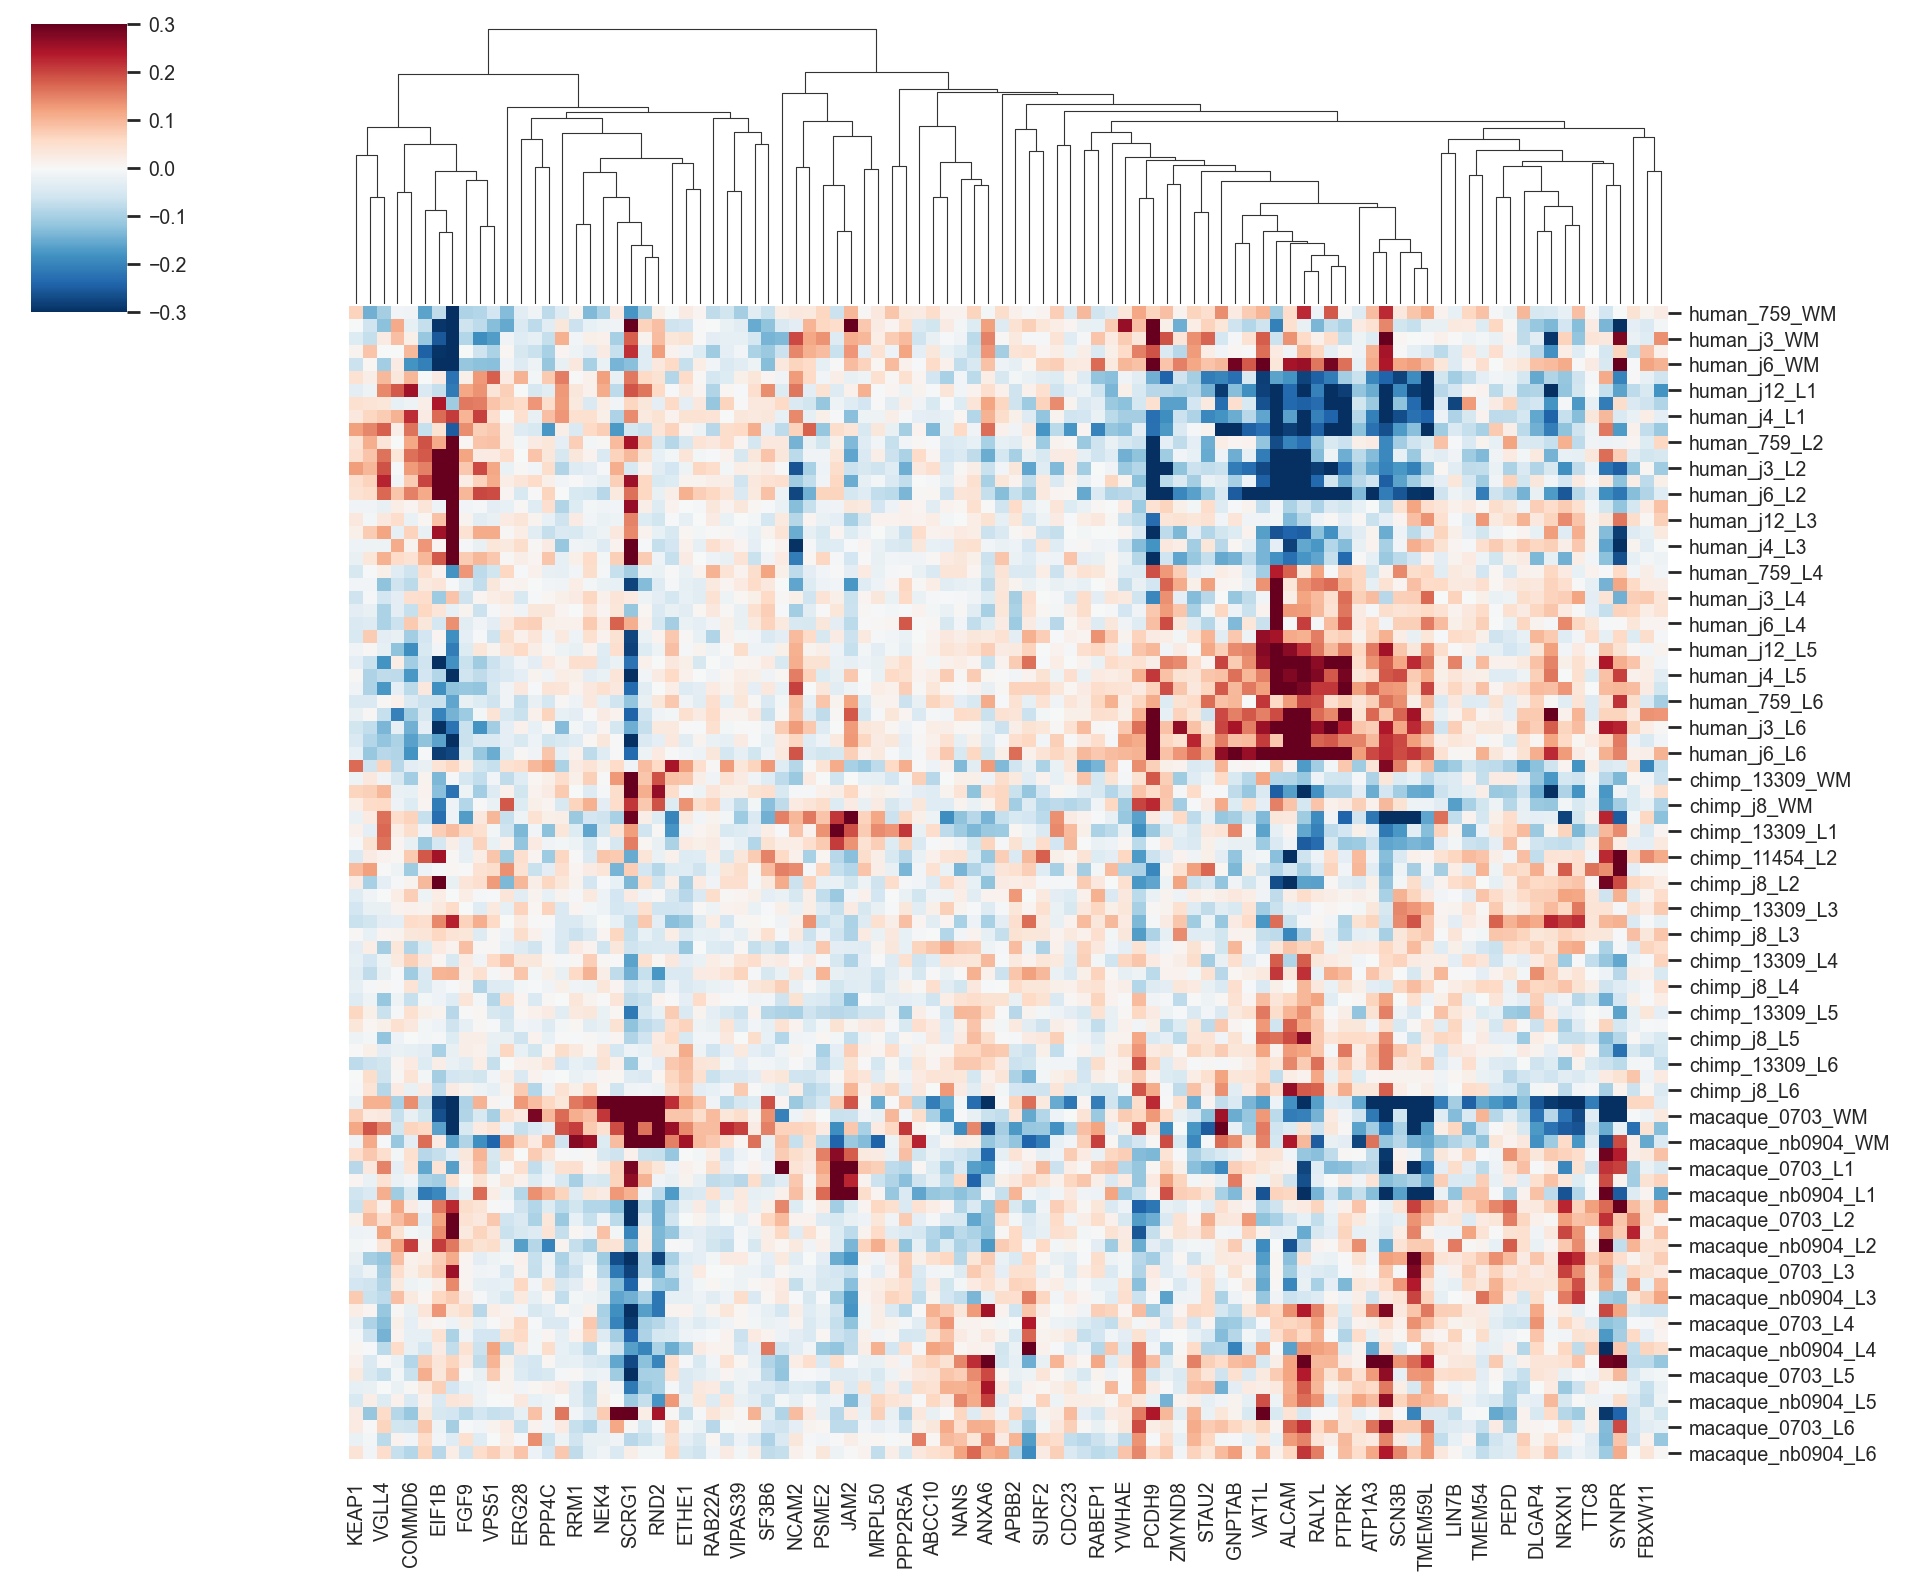

In [21]:
sns.set(font_scale=0.8)
sns.clustermap(df_hs, figsize=(12, 10), cmap="RdBu_r", center=0, vmax=0.3, vmin=-0.3, metric='cosine', annot_kws={"size": 2}, row_cluster=False)

## Spectral clusterisation

In [112]:
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import pairwise_kernels
aff_matrix = pairwise_kernels(df_hs.T, metric='cosine') + 1
n_clusters = 5
clustering = SpectralClustering(n_clusters=n_clusters, affinity='nearest_neighbors', random_state=4)
clustering.fit(df_hs.T)

SpectralClustering(affinity='nearest_neighbors', n_clusters=5, random_state=4)

In [113]:
labels = pd.Series(clustering.labels_, index=hs_genes).sort_values()
order = labels.sort_values().index

In [114]:
labels.to_csv('./results/human_clusters_ancova.csv')

In [115]:
cluster_color = ['red', 'yellow', 'orange', 'green', 'purple', 'blue', 'olive', 'pink', 'brown']

In [116]:
colors = cluster_color[:n_clusters]
clusters = np.arange(n_clusters)

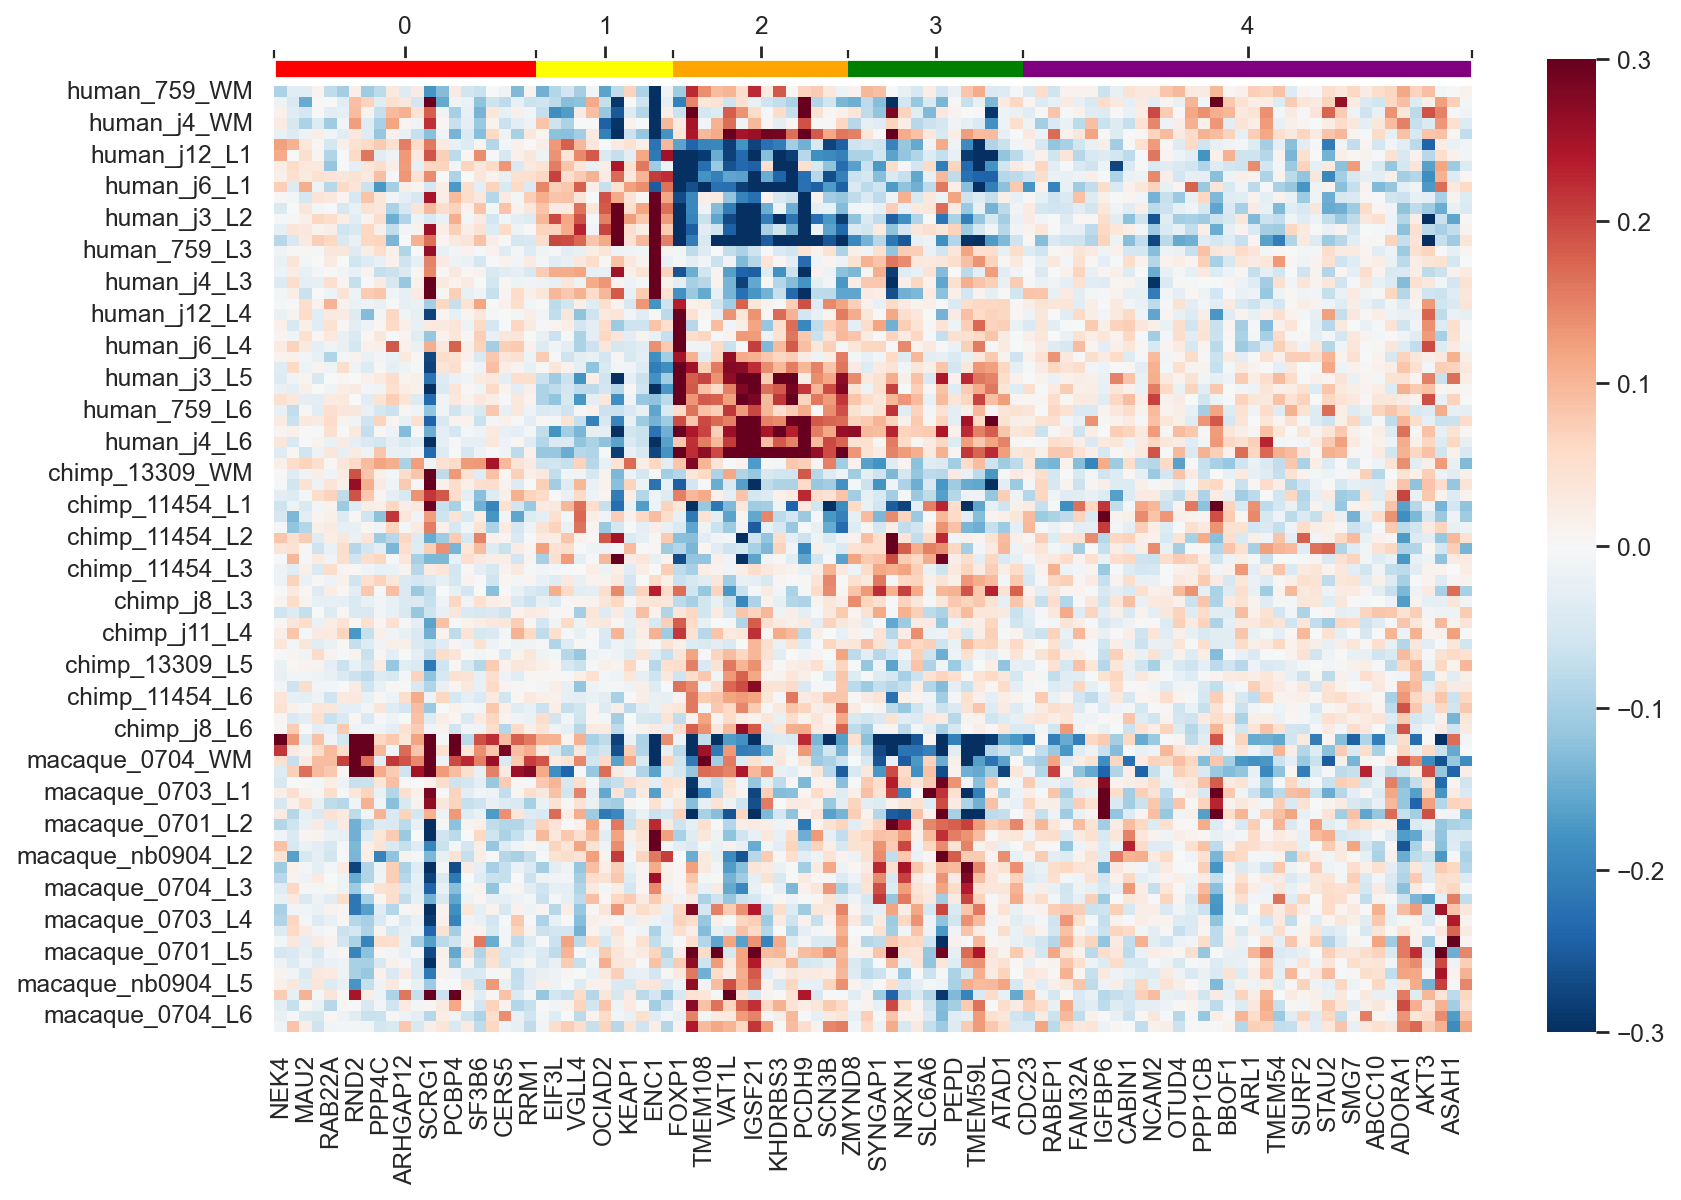

In [117]:
from matplotlib.patches import bbox_artist
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import ticker

fig, ax = plt.subplots(figsize=(12, 8))
sns.heatmap(df_hs[order], ax=ax, cmap="RdBu_r", vmax=0.3, vmin=-0.3, center=0)
divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='2%', pad=0.05)
cmap = mpl.colors.ListedColormap(colors)

cluster_size = labels.value_counts().loc[clusters].values
cluster_pos = cluster_size.cumsum()
bounds = [0] + list(cluster_pos)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
fig.colorbar(
    mpl.cm.ScalarMappable(cmap=cmap, norm=norm),
    cax=cax,
    ticks=bounds,
    orientation='horizontal',
    spacing='proportional'
)
cax.xaxis.set_major_locator(ticker.FixedLocator(cluster_pos - cluster_size / 2))
cax.xaxis.set_major_formatter(ticker.FixedFormatter(clusters))
cax.xaxis.tick_top()

In [118]:
labels[labels == 1].size

11

## Cluster profiles

In [119]:
df_annotation = df_hs.copy()
df_annotation['layer'] = adata_pb_norm.obs.layer
df_annotation['condition'] = adata_pb_norm.obs.condition

In [120]:
layer_mean = df_annotation.groupby(['condition', 'layer']).mean()
layer_mean.head()

ABCC10    ADORA1    AHNAK2      AKT3     ALCAM     ANXA6  \
condition layer                                                               
chimp     L1     0.012161 -0.142581 -0.091653 -0.012988  0.009130 -0.061217   
          L2     0.007172 -0.145785 -0.052059 -0.013202 -0.242804 -0.096782   
          L3    -0.008038 -0.120843 -0.010910  0.004795 -0.066325 -0.037331   
          L4     0.024499  0.006139  0.062326 -0.005160  0.006249  0.023248   
          L5    -0.001435  0.065859  0.082473 -0.032334  0.134409  0.042378   

                    APBB2  ARHGAP12      ARL1     ASAH1  ...    TMEM54  \
condition layer                                          ...             
chimp     L1     0.000521  0.015205  0.075436 -0.031851  ... -0.047150   
          L2     0.009758  0.050214 -0.029062  0.066117  ...  0.062359   
          L3     0.064595 -0.031278 -0.014887  0.052351  ...  0.023326   
          L4     0.065062 -0.014705  0.010534  0.038820  ...  0.004013   
          L5    -0.020785 -0.010368  0.006963  0.015541  ... -0.000069   

                  TMEM59L      TTC8     VAT1L     VGLL4   VIPAS39     VPS51  \
condition layer                                                               
chimp     L1    -0.143562 -0.012932 -0.134595  0.167036 -0.059544  0.023511   
          L2    -0.011356  0.052833 -0.027984 -0.005204  0.045883  0.087736   
          L3     0.074531  0.038487 -0.090556 -0.011697 -0.000079  0.021849   
          L4     0.034858 -0.014698 -0.019777 -0.033863  0.029193  0.004273   
          L5     0.013617 -0.026738  0.138460 -0.070231 -0.027980 -0.040454   

                    YWHAE    ZBTB46    ZMYND8  
condition layer                                
chimp     L1    -0.043822  0.026107 -0.001521  
          L2     0.006897  0.072883  0.059591  
          L3     0.031802  0.070541  0.063579  
          L4     0.006790  0.024286  0.019230  
          L5     0.007214 -0.064324 -0.050828  

[5 rows x 96 columns]

In [121]:
# fig, axes = plt.subplots(2, 2,  figsize=(14, 3.5 * 2), gridspec_kw={'hspace': 0.4})
# for gene, ax in zip(layer_mean.columns, axes.flatten()):
#     (
#             layer_mean[gene]
#             .reorder_levels(['layer', 'condition'])
#             .unstack().loc[layers]
#             .plot
#             .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green'}, ax=ax, marker='.')
#     )
#     ax.grid(False)

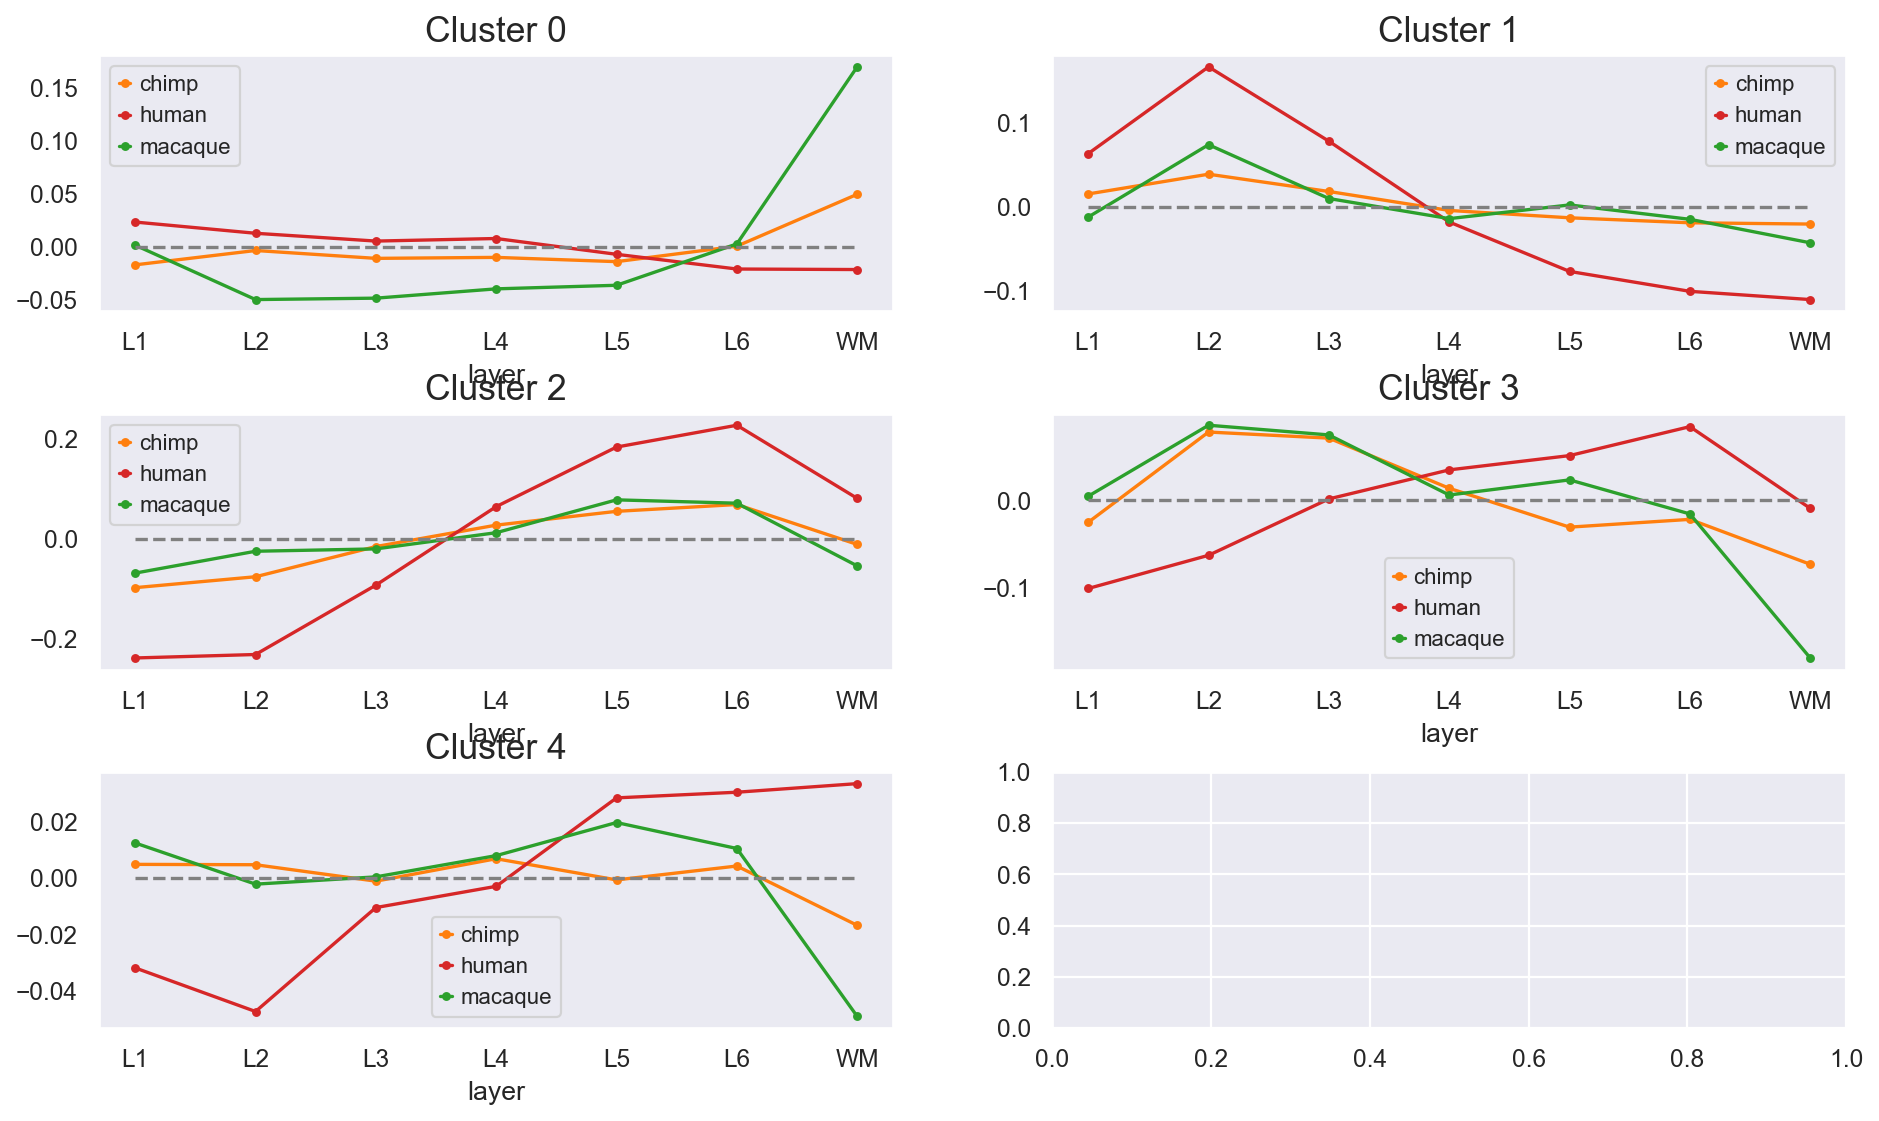

In [122]:
fig, axes = plt.subplots((n_clusters + 1) // 2, 2,  figsize=(14, 3.5 * n_clusters // 2), gridspec_kw={'hspace': 0.4})
sns.set(font_scale=1)
for label, ax in zip(labels.unique(), axes.flatten()):
    genes = labels[labels == label].index.tolist()

    (
        layer_mean[genes]
        .mean(axis=1)
        .reorder_levels(['layer', 'condition'])
        .unstack().loc[layers]
        .plot
        .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green'}, ax=ax, marker='.')
    )
    ax.legend(fontsize=10)
    ax.set_title(f'Cluster {label}', fontsize=16)
    ax.grid(False)
    ax.hlines(0, xmin=0, xmax=6, colors='gray', linestyles='dashed')

Text(0.5, 0.98, 'Median everaging for profiles')

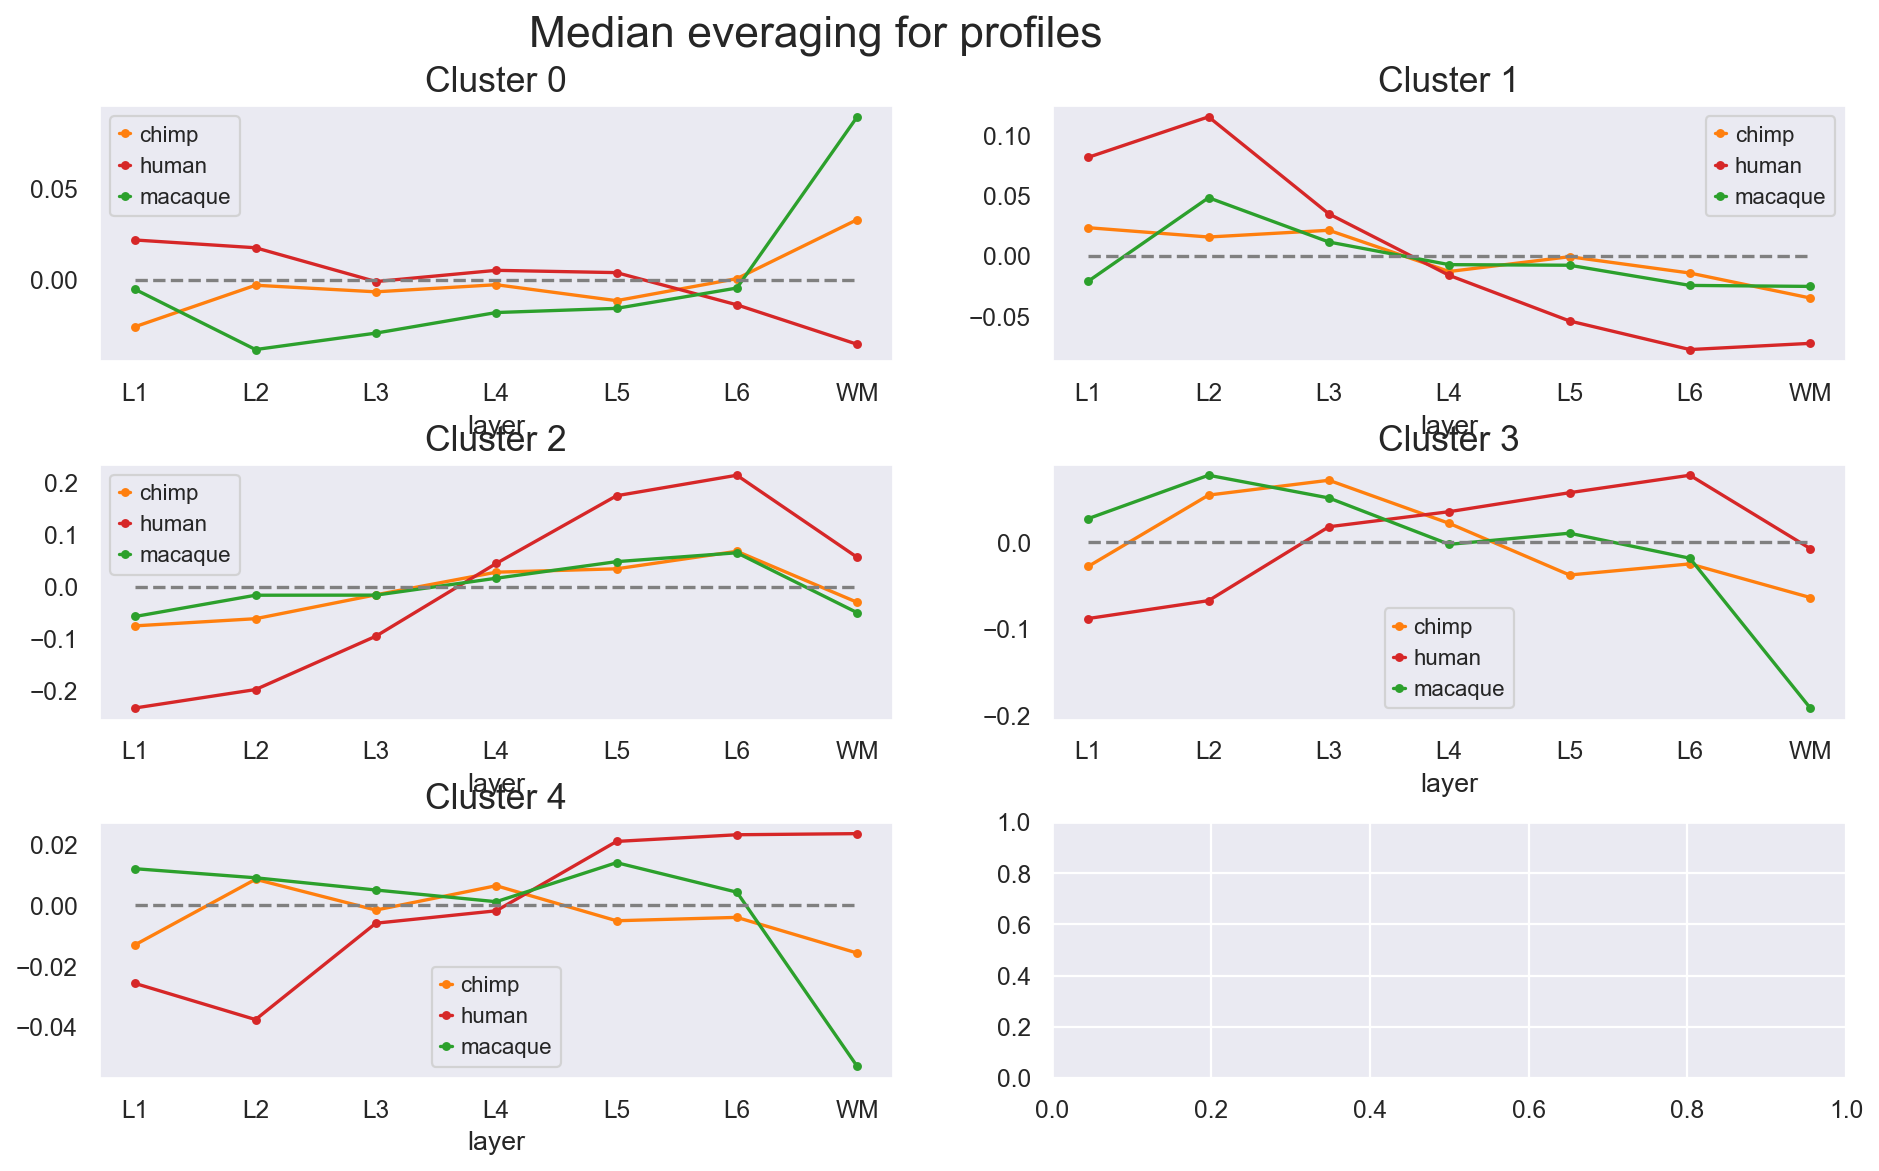

In [123]:
fig, axes = plt.subplots((n_clusters + 1) // 2, 2,  figsize=(14, 3.5 * n_clusters // 2), gridspec_kw={'hspace': 0.4})
sns.set(font_scale=1)
for label, ax in zip(labels.unique(), axes.flatten()):
    genes = labels[labels == label].index.tolist()

    (
        layer_mean[genes]
        .median(axis=1)
        .reorder_levels(['layer', 'condition'])
        .unstack().loc[layers]
        .plot
        .line(color={'human': 'tab:red', 'chimp': 'tab:orange', 'macaque': 'tab:green'}, ax=ax, marker='.')
    )
    ax.legend(fontsize=10)
    ax.set_title(f'Cluster {label}', fontsize=16)
    ax.grid(False)
    ax.hlines(0, xmin=0, xmax=6, colors='gray', linestyles='dashed')

fig.suptitle('Median everaging for profiles', fontsize=20)

# Intersection with ANOVA clusters

In [124]:
anova_hs_inter = hs_genes.intersection(anova_labels.index)
anova_hs_inter

Index(['ABCC10', 'ADORA1', 'AHNAK2', 'AKT3', 'ALCAM', 'ANXA6', 'APBB2',
       'ARHGAP12', 'ARL1', 'ASAH1', 'ATAD1', 'ATP1A3', 'ATP5F1E', 'BBOF1',
       'CABIN1', 'CDC23', 'CDK8', 'CERS5', 'COMMD6', 'DLGAP4', 'DMAP1',
       'EIF1B', 'EIF4E3', 'EIF4G3', 'ENC1', 'ERG28', 'ETHE1', 'FBXW11', 'FGF9',
       'FOXP1', 'FYN', 'GNPTAB', 'GTF3C2', 'IGFBP2', 'IGFBP6', 'IGSF21',
       'JAM2', 'KEAP1', 'KHDRBS3', 'KIF21B', 'KLHDC8B', 'LIN7B', 'MAU2',
       'MRPL50', 'NANS', 'NCAM2', 'NEK4', 'NIM1K', 'NRXN1', 'NRXN2', 'OCIAD2',
       'OTUD4', 'PCBP4', 'PCDH9', 'PDIA3', 'PEPD', 'PHYHIP', 'PPP1CC',
       'PPP2R5A', 'PPP4C', 'PSME2', 'PTPRK', 'RAB22A', 'RALYL', 'RND2',
       'RNF40', 'RRM1', 'SCN3B', 'SCRG1', 'SF3B6', 'SMG7', 'SND1', 'STAU2',
       'SYNGAP1', 'SYNPR', 'THY1', 'TMEM108', 'TMEM54', 'TMEM59L', 'TTC8',
       'VAT1L', 'VGLL4', 'VIPAS39', 'VPS51', 'YWHAE', 'ZBTB46', 'ZMYND8'],
      dtype='object')

In [125]:
table_to_pivot = pd.concat([anova_labels.loc[anova_hs_inter], labels.loc[anova_hs_inter]], axis=1)
table_to_pivot.columns = ['ANOVA_labels', 'hs_labels']
pivot_labels_inter = table_to_pivot.groupby('ANOVA_labels').value_counts().unstack().fillna(0)
pivot_labels_inter

hs_labels,0,1,2,3,4
ANOVA_labels,,,,,
0,4.0,7.0,0.0,0.0,0.0
1,0.0,1.0,1.0,0.0,7.0
2,0.0,0.0,13.0,7.0,7.0
3,12.0,0.0,0.0,0.0,0.0
4,2.0,1.0,0.0,0.0,2.0
5,1.0,1.0,0.0,5.0,6.0
6,0.0,0.0,0.0,1.0,9.0


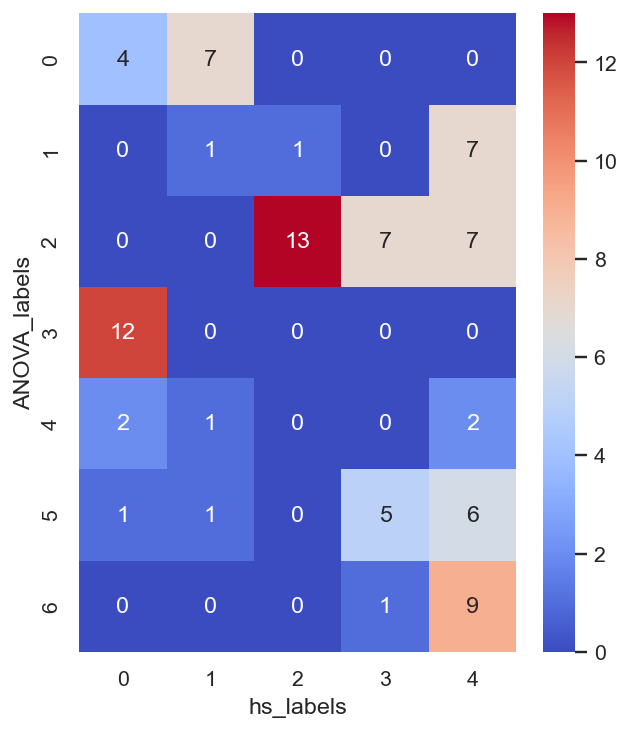

In [126]:
plt.figure(figsize=(5, 6), dpi=70)
sns.set(font_scale=1)
sns.heatmap(pivot_labels_inter, annot=True, cmap = 'coolwarm', fmt=".0f")
plt.grid(False)

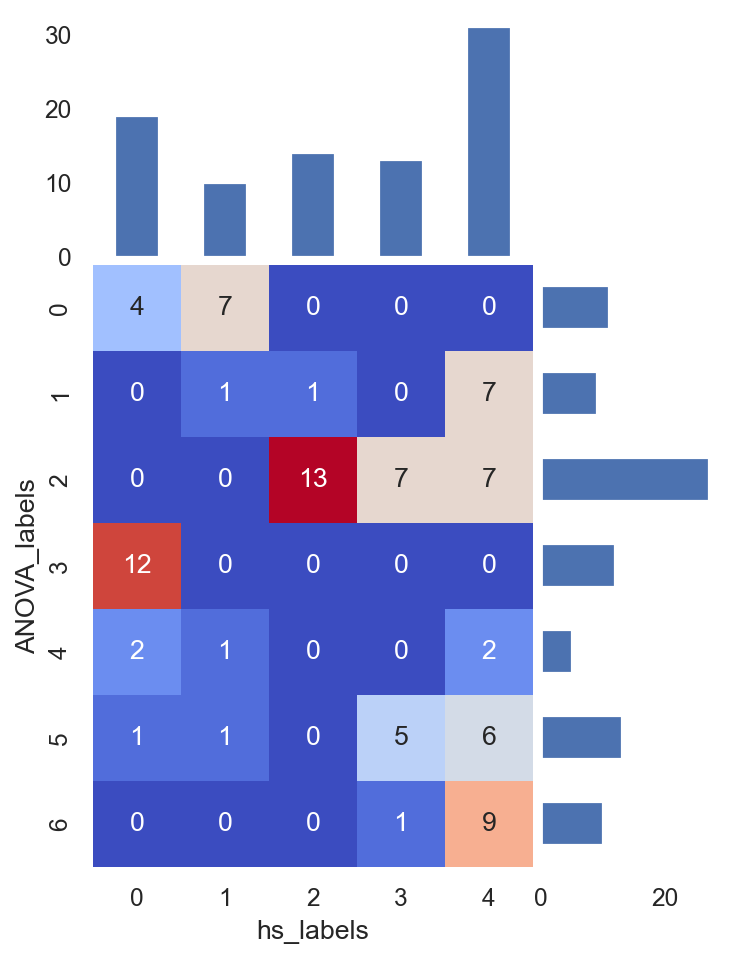

In [127]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
fig, ax = plt.subplots(figsize=(5, 7))
sns.heatmap(pivot_labels_inter, annot=True, cmap = 'coolwarm', fmt=".0f", ax=ax, cbar=False)


divider = make_axes_locatable(ax)
cax = divider.append_axes('top', size='40%', pad=0.05)
pivot_labels_inter.sum(axis=0).plot.bar(ax=cax)
cax.set_facecolor(color='white')
cax.get_xaxis().set_visible(False)

cax = divider.append_axes('right', size='40%', pad=0.05)
index_order = pivot_labels_inter.index[::-1]
pivot_labels_inter.sum(axis=1).loc[index_order].plot.barh(ax=cax)
cax.set_facecolor(color='white')
cax.get_yaxis().set_visible(False)

# Functional analysis

In [128]:
gene_clust = list()
enrich_results = list()

for label in tqdm(sorted(labels.unique())):
    genes = labels[labels == label].index.tolist()
    descr = f'Genes for spectral clustering ({n_clusters} clusters) of human-specific genes. Cluster label: {label}'
    gene_clust.append(GeneCluster(genes, descr, label, background_genes))
    time.sleep(1)

  0%|          | 0/5 [00:00<?, ?it/s]

## GO_Biological_Process_2021

In [129]:
GeneCluster.enrich_geneclusters(gene_clust, 'GO_Biological_Process_2021')

In [130]:
enrich_res = pd.concat([gc.enrichment_res['GO_Biological_Process_2021'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

,Rank,p-val,Z-score,Combined score,Overlapping genes,Adjusted P-value,Old p-value,Old adjusted p-value,num_overlap_genes,neg_log10(p_adj),cluster_label
Term,,,,,,,,,,,
regulation of hydrogen peroxide biosynthetic process (GO:0010728),1,0.003896,inf,inf,[FYN],0.140287,0,0,1,0.852984,0
negative regulation of hydrogen peroxide metabolic process (GO:0010727),2,0.003896,inf,inf,[FYN],0.140287,0,0,1,0.852984,0
regulation of glutamate receptor signaling pathway (GO:1900449),3,0.007778,268.4,1303.484532,[FYN],0.140287,0,0,1,0.852984,0
sulfide oxidation (GO:0019418),4,0.007778,268.4,1303.484532,[ETHE1],0.140287,0,0,1,0.852984,0
"sulfide oxidation, using sulfide:quinone oxidoreductase (GO:0070221)",5,0.007778,268.4,1303.484532,[ETHE1],0.140287,0,0,1,0.852984,0


In [131]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

9

In [132]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

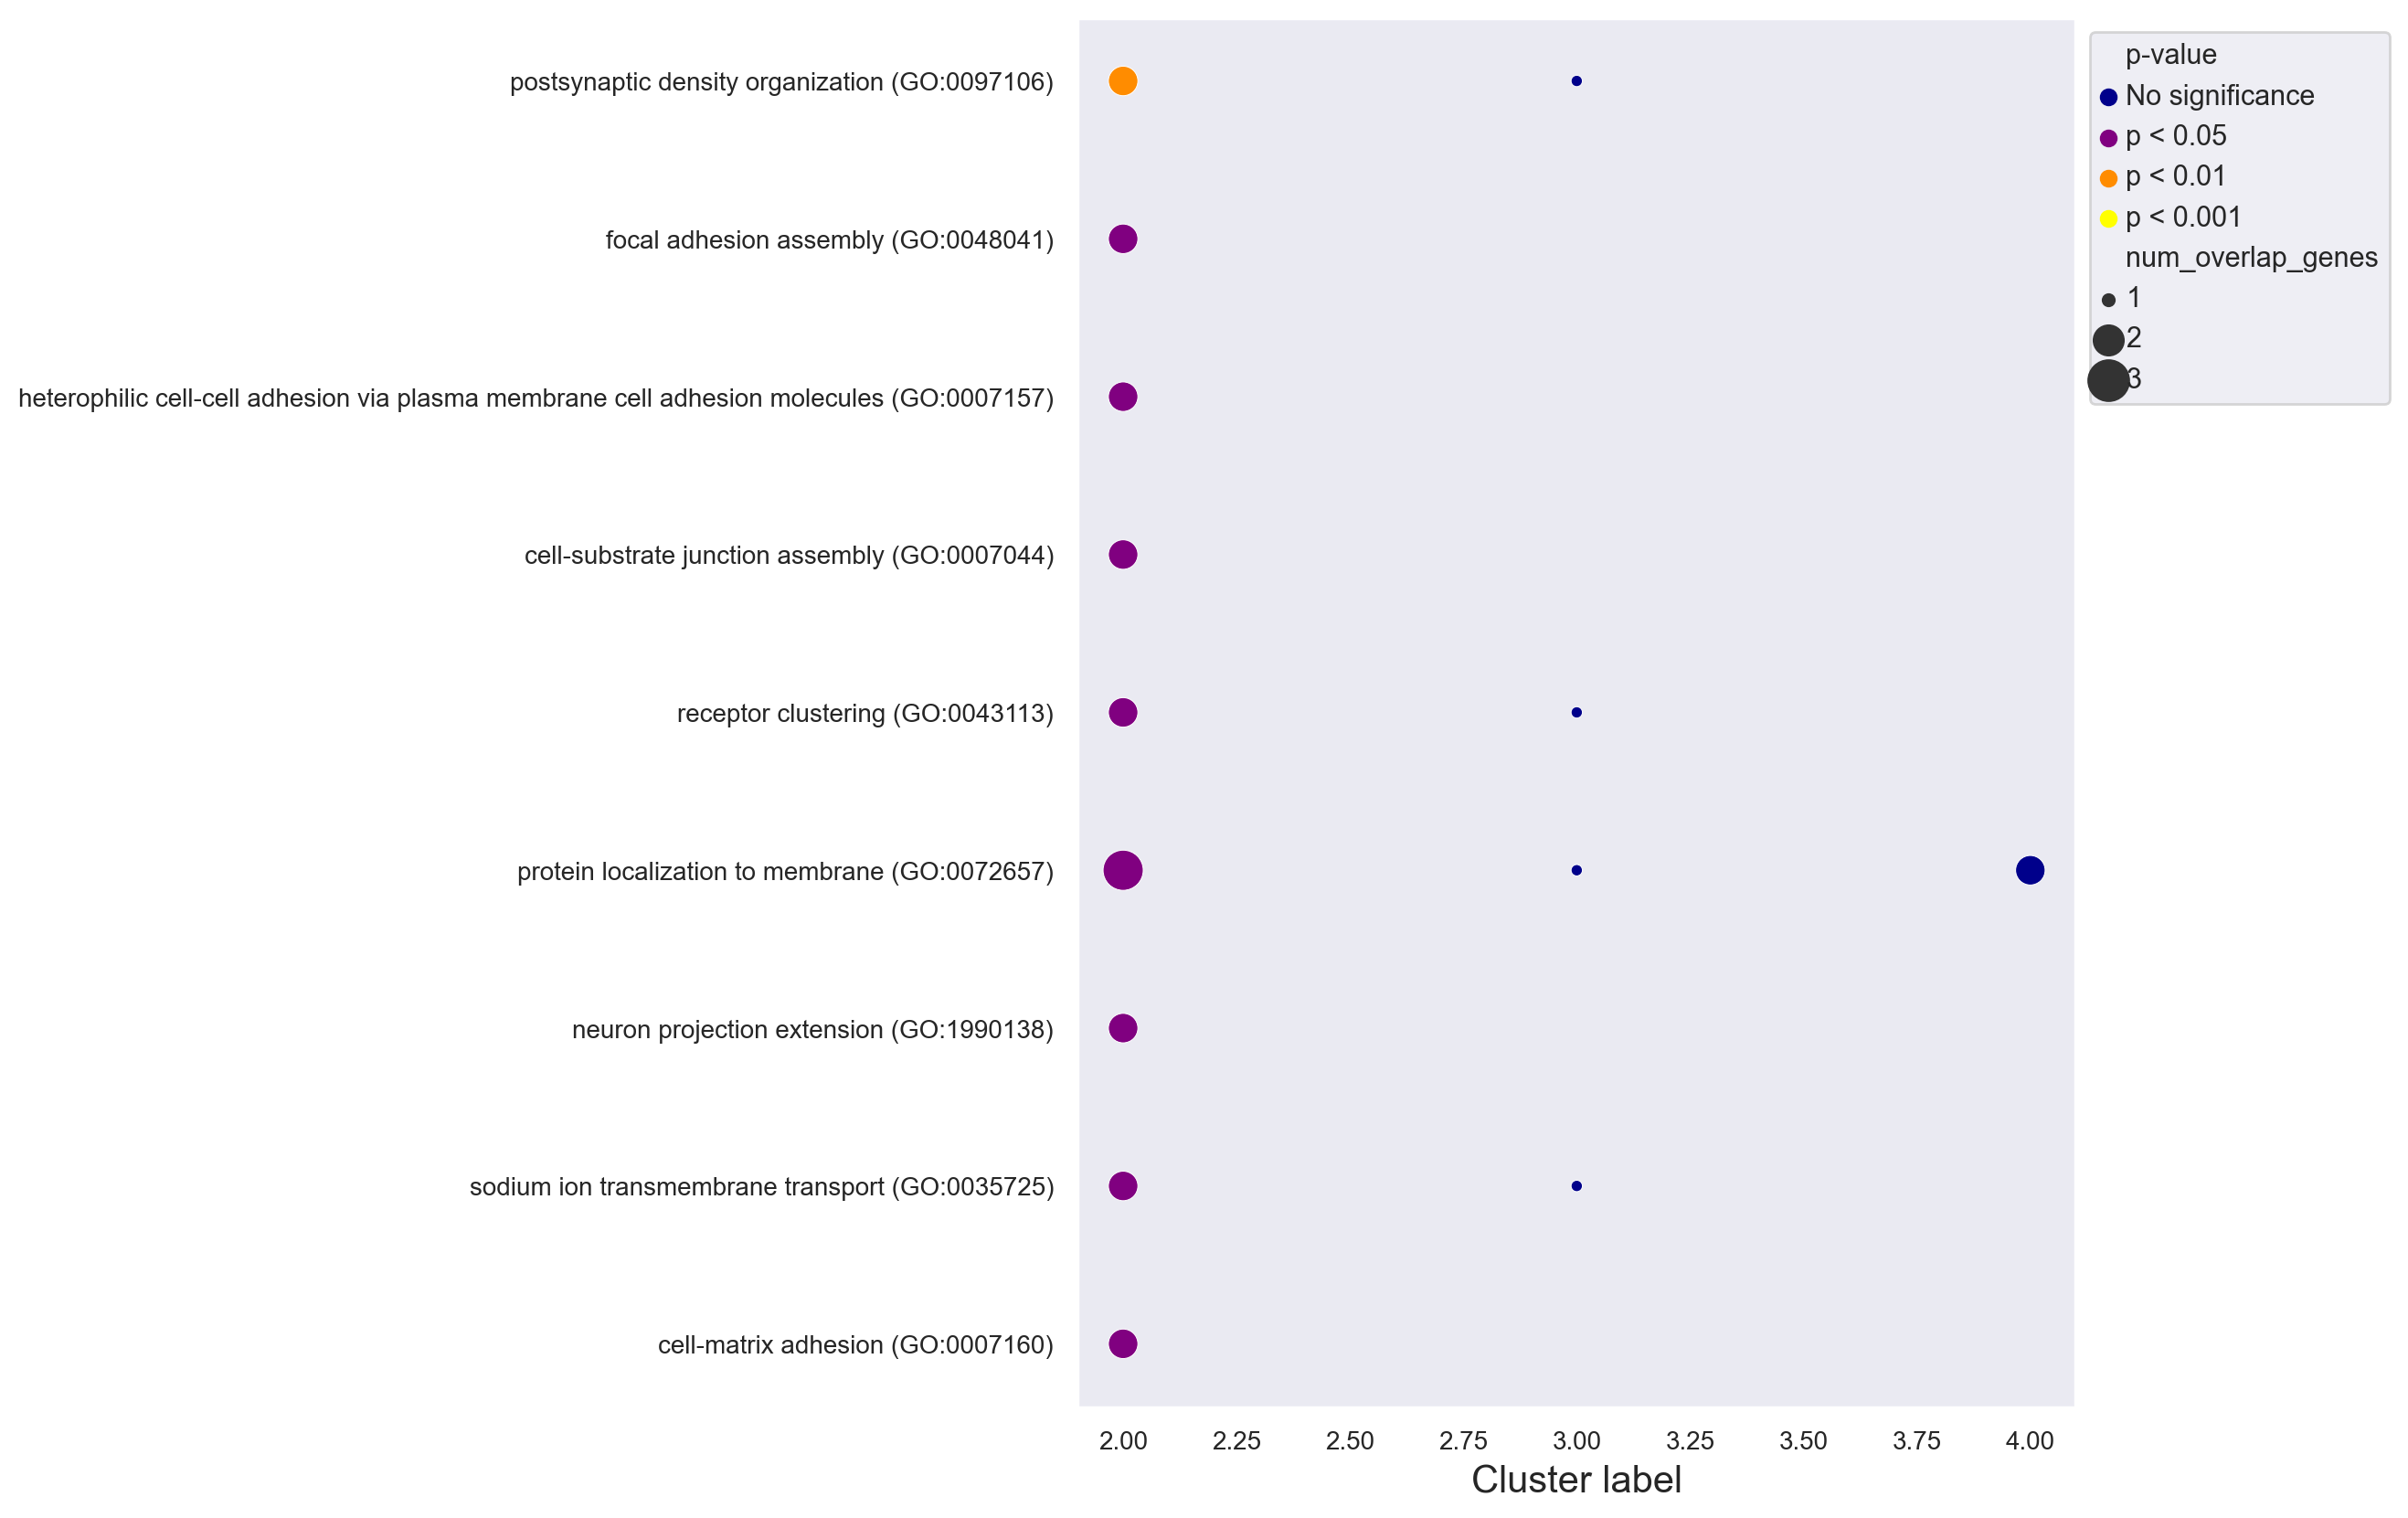

In [133]:
fig = plt.figure(figsize=(7, 10), dpi=100)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Azimuth Cell Types 2021


In [134]:
GeneCluster.enrich_geneclusters(gene_clust, 'Azimuth_Cell_Types_2021')

In [135]:
enrich_res = pd.concat([gc.enrichment_res['Azimuth_Cell_Types_2021'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

,Rank,p-val,Z-score,Combined score,Overlapping genes,Adjusted P-value,Old p-value,Old adjusted p-value,num_overlap_genes,neg_log10(p_adj),cluster_label
Term,,,,,,,,,,,
LINC00507+ GLRA3+ Layer 2 Glutamatergic Neuron CL0000679,1,0.004078,537.800000,2959.083673,[ENC1],0.006111,0,0,1,2.213886,1
"Layer 2-3 Glutamatergic Neuron, Intratelencephalon-Projecting CL0000679",2,0.006111,268.850000,1370.506406,[ENC1],0.006111,0,0,1,2.213886,1
Glutamatergic Neuron CL0000679,1,0.000093,223.833333,2076.802507,"[RALYL, KHDRBS3]",0.001869,0,0,2,2.728503,2
SST+ OR5AH1P+ Layer 3-5 GABAergic Neuron CL0000617,2,0.005188,413.461538,2175.351938,[PCDH9],0.008637,0,0,1,2.063635,2
"Layer 6 Glutamatergic Neuron, Intratelencephalon-Projecting CL0000679",3,0.005188,413.461538,2175.351938,[PTPRK],0.008637,0,0,1,2.063635,2


In [136]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05) & (enrich_res.Rank < 10)].index.unique()
terms.size

23

In [137]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

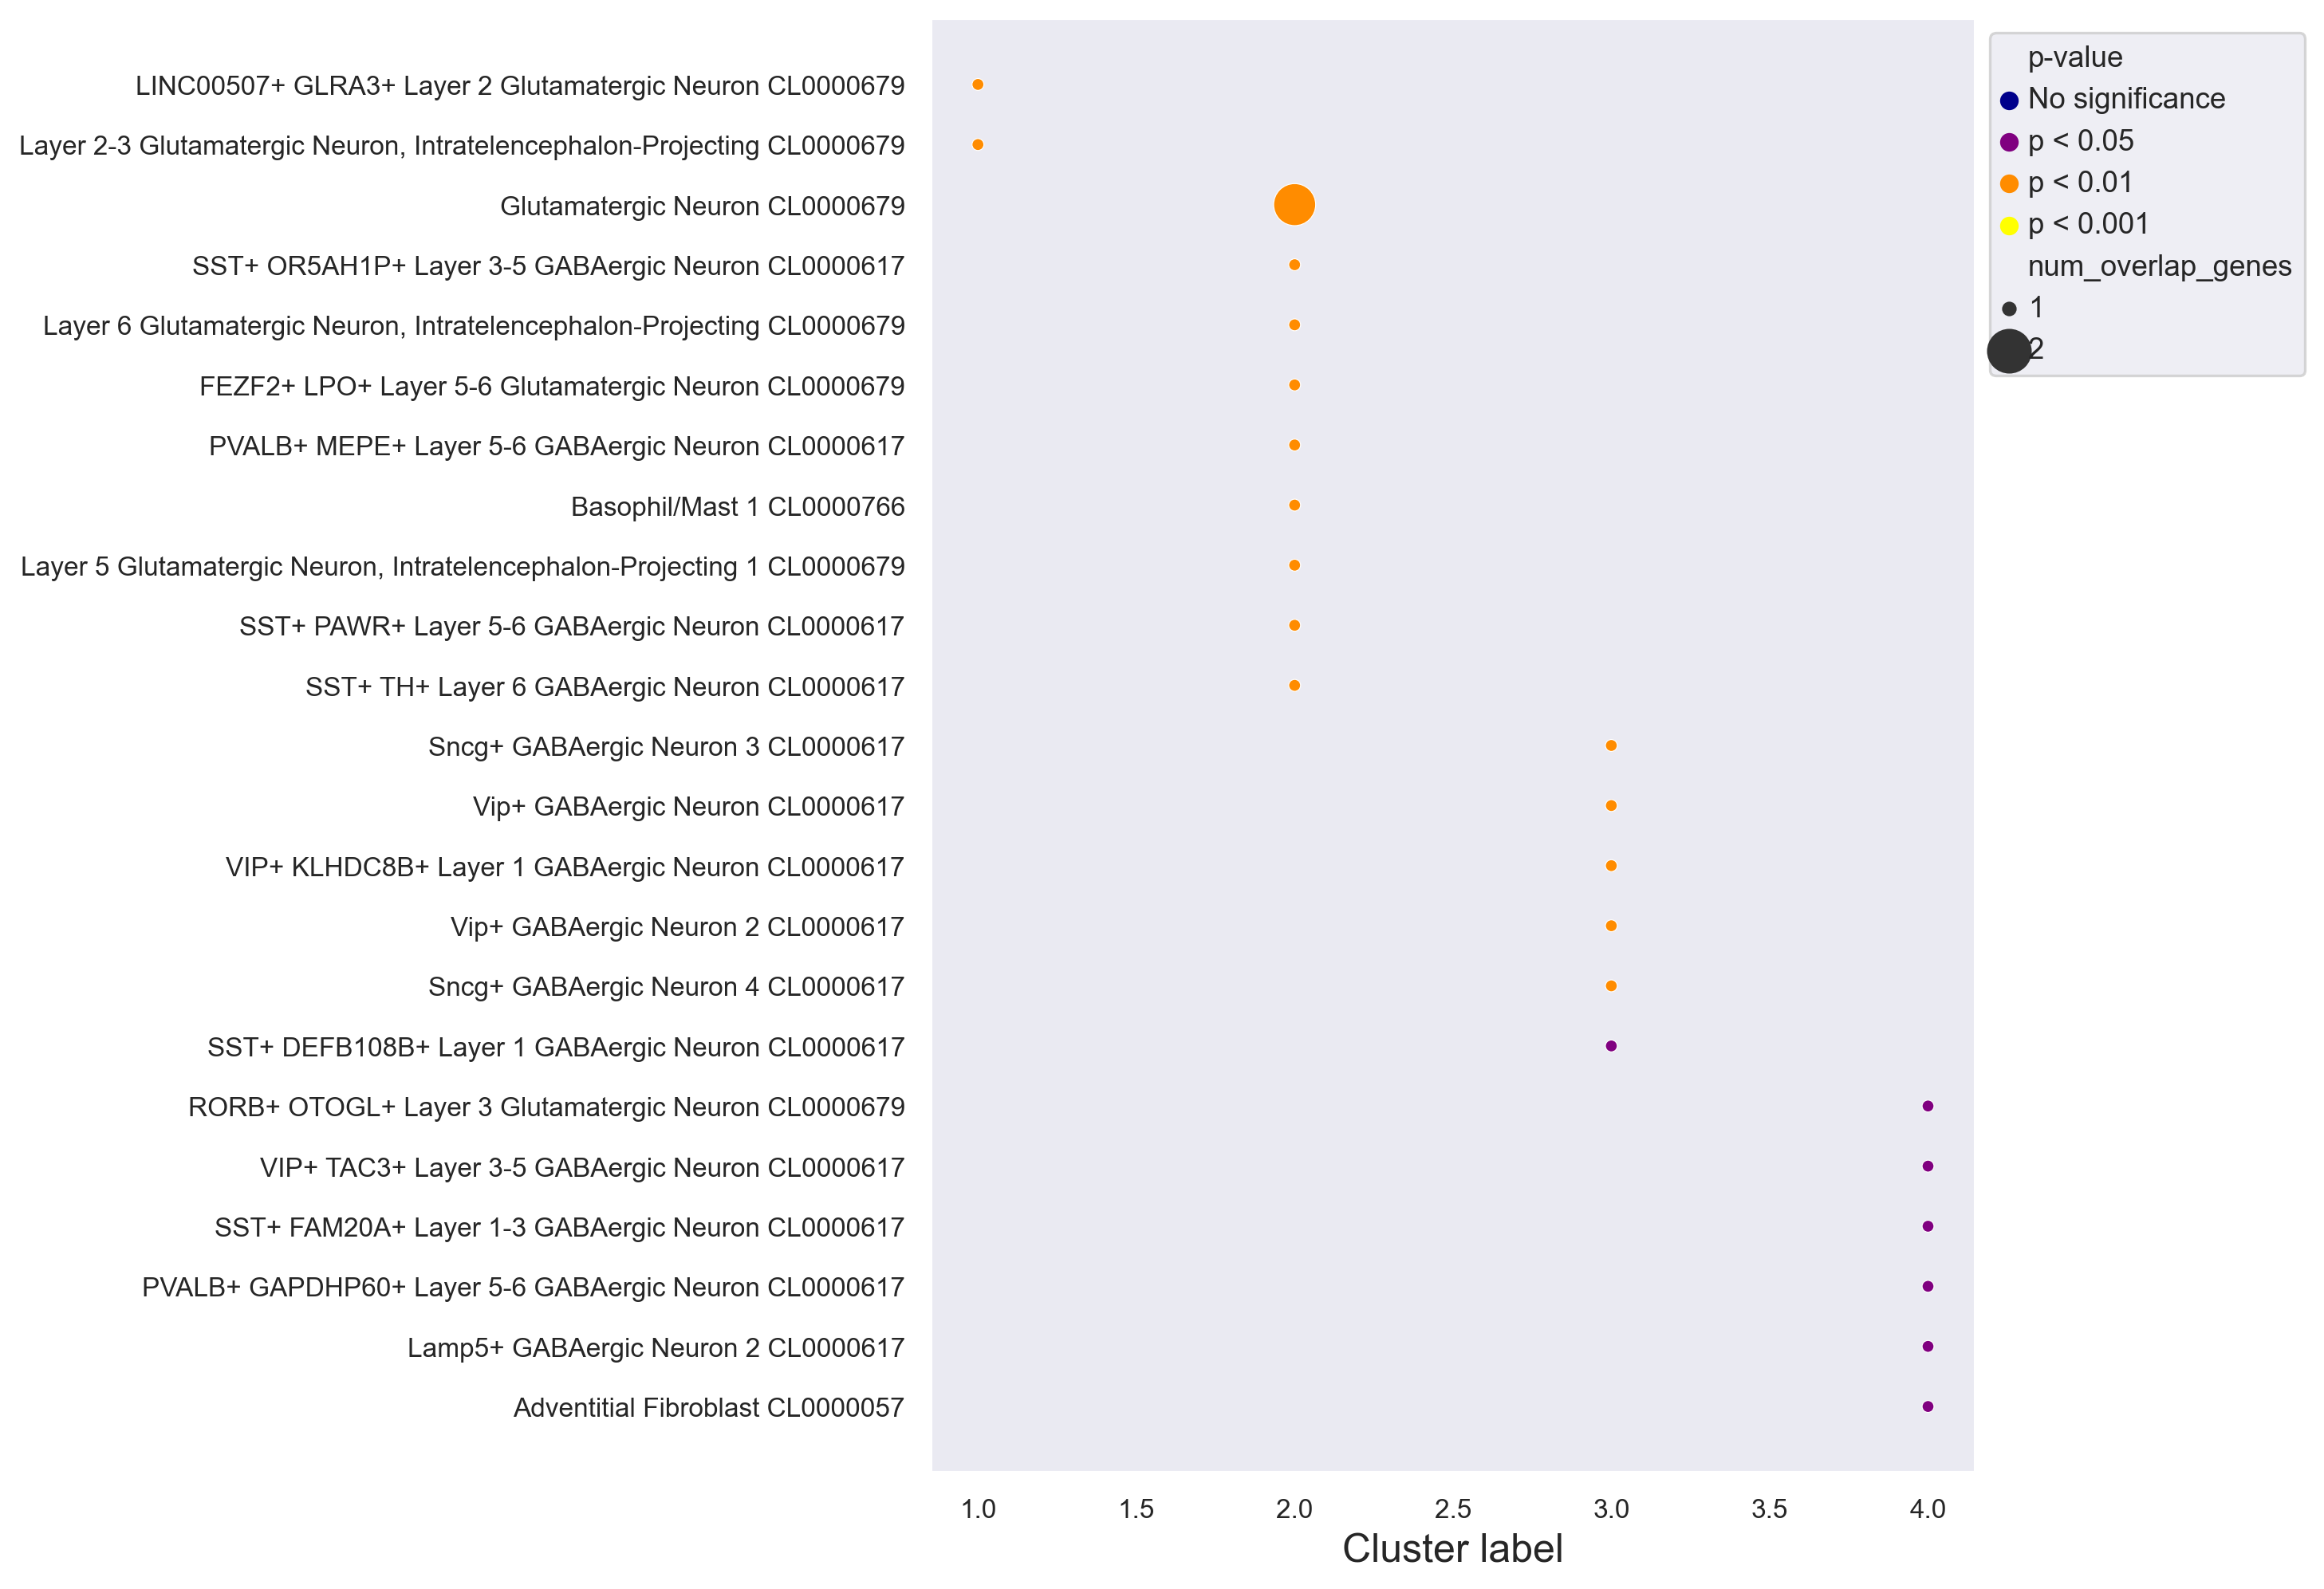

In [138]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## MGI_Mammalian_Phenotype_Level_4_2021

In [139]:
GeneCluster.enrich_geneclusters(gene_clust, 'MGI_Mammalian_Phenotype_Level_4_2021')

In [140]:
enrich_res = pd.concat([gc.enrichment_res['MGI_Mammalian_Phenotype_Level_4_2021'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

,Rank,p-val,Z-score,Combined score,Overlapping genes,Adjusted P-value,Old p-value,Old adjusted p-value,num_overlap_genes,neg_log10(p_adj),cluster_label
Term,,,,,,,,,,,
enhanced behavioral response to alcohol MP:0009751,1,0.003896,inf,inf,[FYN],0.121247,0,0,1,0.916329,0
abnormal immune cell physiology MP:0001819,2,0.003896,inf,inf,[FYN],0.121247,0,0,1,0.916329,0
abnormal lymph node morphology MP:0002339,3,0.006281,19.38294,98.276197,"[PPP2R5A, RND2]",0.121247,0,0,2,0.916329,0
abnormal T cell clonal deletion MP:0005002,4,0.007778,268.40000,1303.484532,[FYN],0.121247,0,0,1,0.916329,0
abnormal Sertoli cell barrier morphology MP:0020355,5,0.007778,268.40000,1303.484532,[FYN],0.121247,0,0,1,0.916329,0


In [141]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05)].index.unique()
terms.size

62

In [142]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

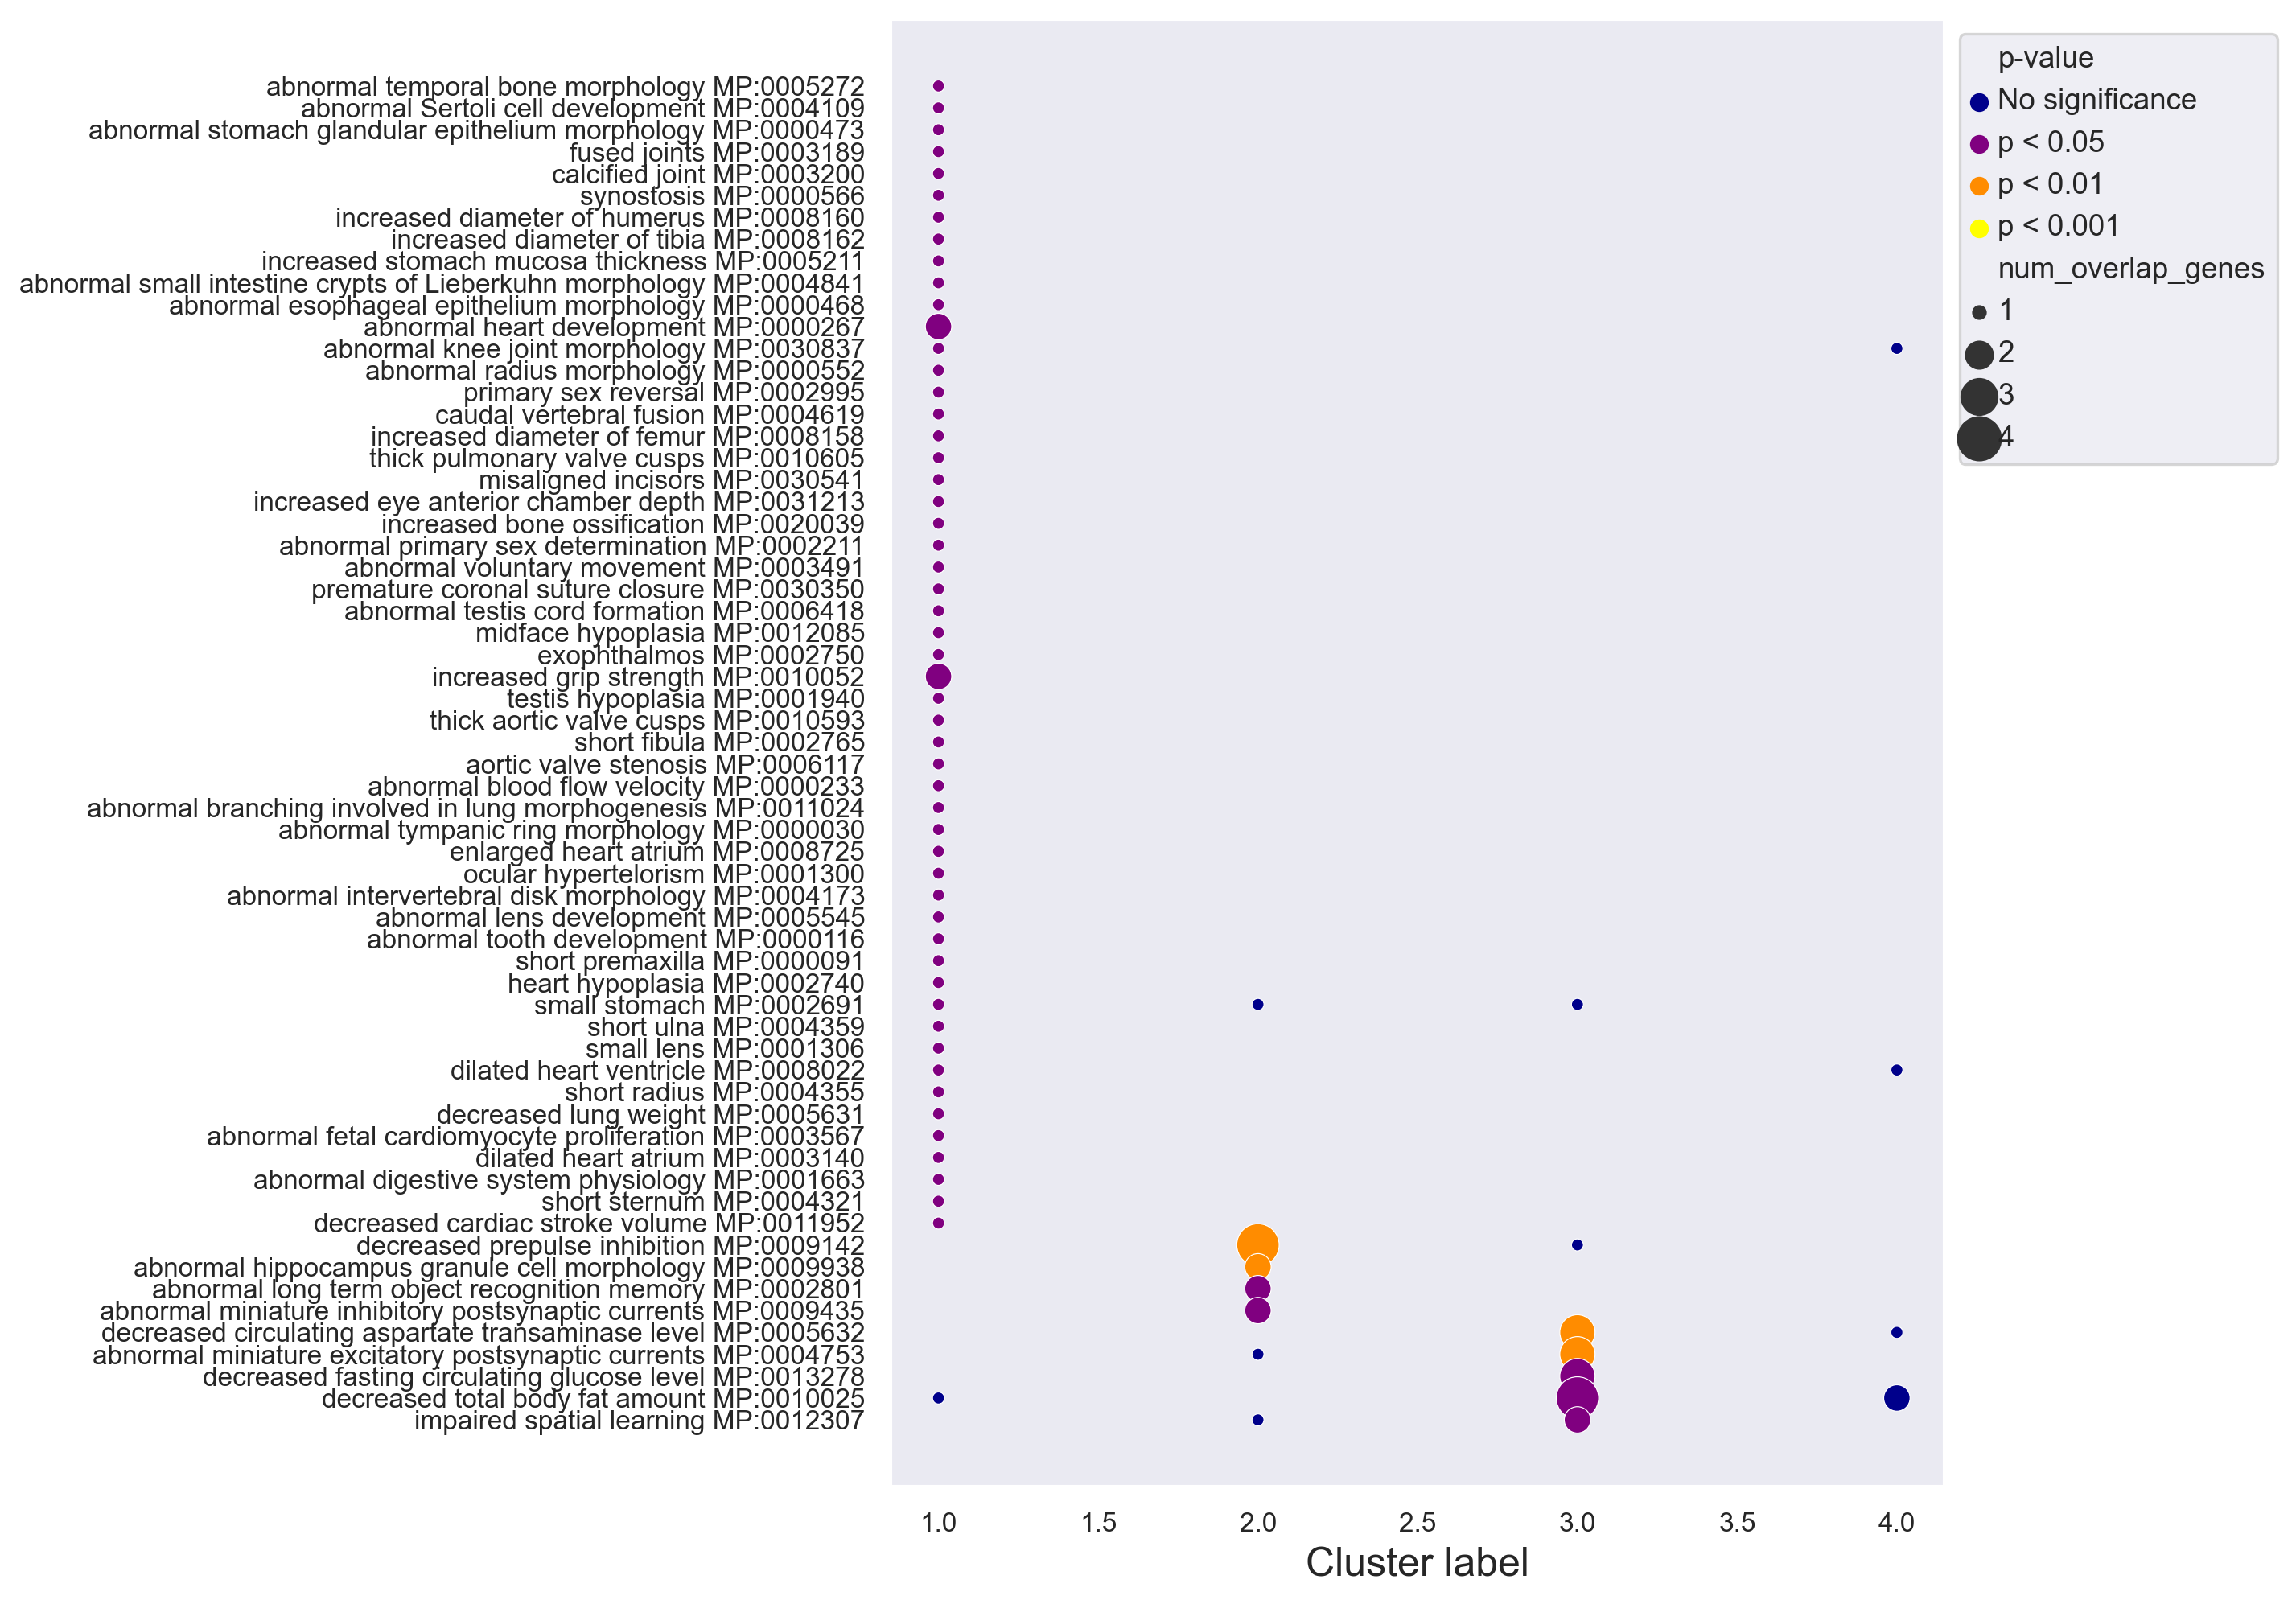

In [143]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## Reactome_2022

In [144]:
GeneCluster.enrich_geneclusters(gene_clust, 'Reactome_2022')

In [145]:
enrich_res = pd.concat([gc.enrichment_res['Reactome_2022'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

,Rank,p-val,Z-score,Combined score,Overlapping genes,Adjusted P-value,Old p-value,Old adjusted p-value,num_overlap_genes,neg_log10(p_adj),cluster_label
Term,,,,,,,,,,,
CTLA4 Inhibitory Signaling R-HSA-389513,1,0.001099,51.272727,349.338783,"[PPP2R5A, FYN]",0.142331,0,0,2,0.8467,0
Costimulation By CD28 Family R-HSA-388841,2,0.003482,26.807018,151.731389,"[PPP2R5A, FYN]",0.142331,0,0,2,0.8467,0
FLT3 Signaling Thru SRC Family Kinases R-HSA-9706374,3,0.003896,inf,inf,[FYN],0.142331,0,0,1,0.8467,0
"PI5P, PP2A And IER3 Regulate PI3K/AKT Signaling R-HSA-6811558",4,0.006281,19.382940,98.276197,"[PPP2R5A, FYN]",0.142331,0,0,2,0.8467,0
Diseases Of Signal Transduction By Growth Factor Receptors And Second Messengers R-HSA-5663202,5,0.006583,6.243137,31.360913,"[CDK8, PPP2R5A, FYN, SND1]",0.142331,0,0,4,0.8467,0


In [146]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05)].index.unique()
terms.size

0

In [147]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

C:\Users\aleks\AppData\Local\Temp\ipykernel_22296\3967478431.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.scatterplot(
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


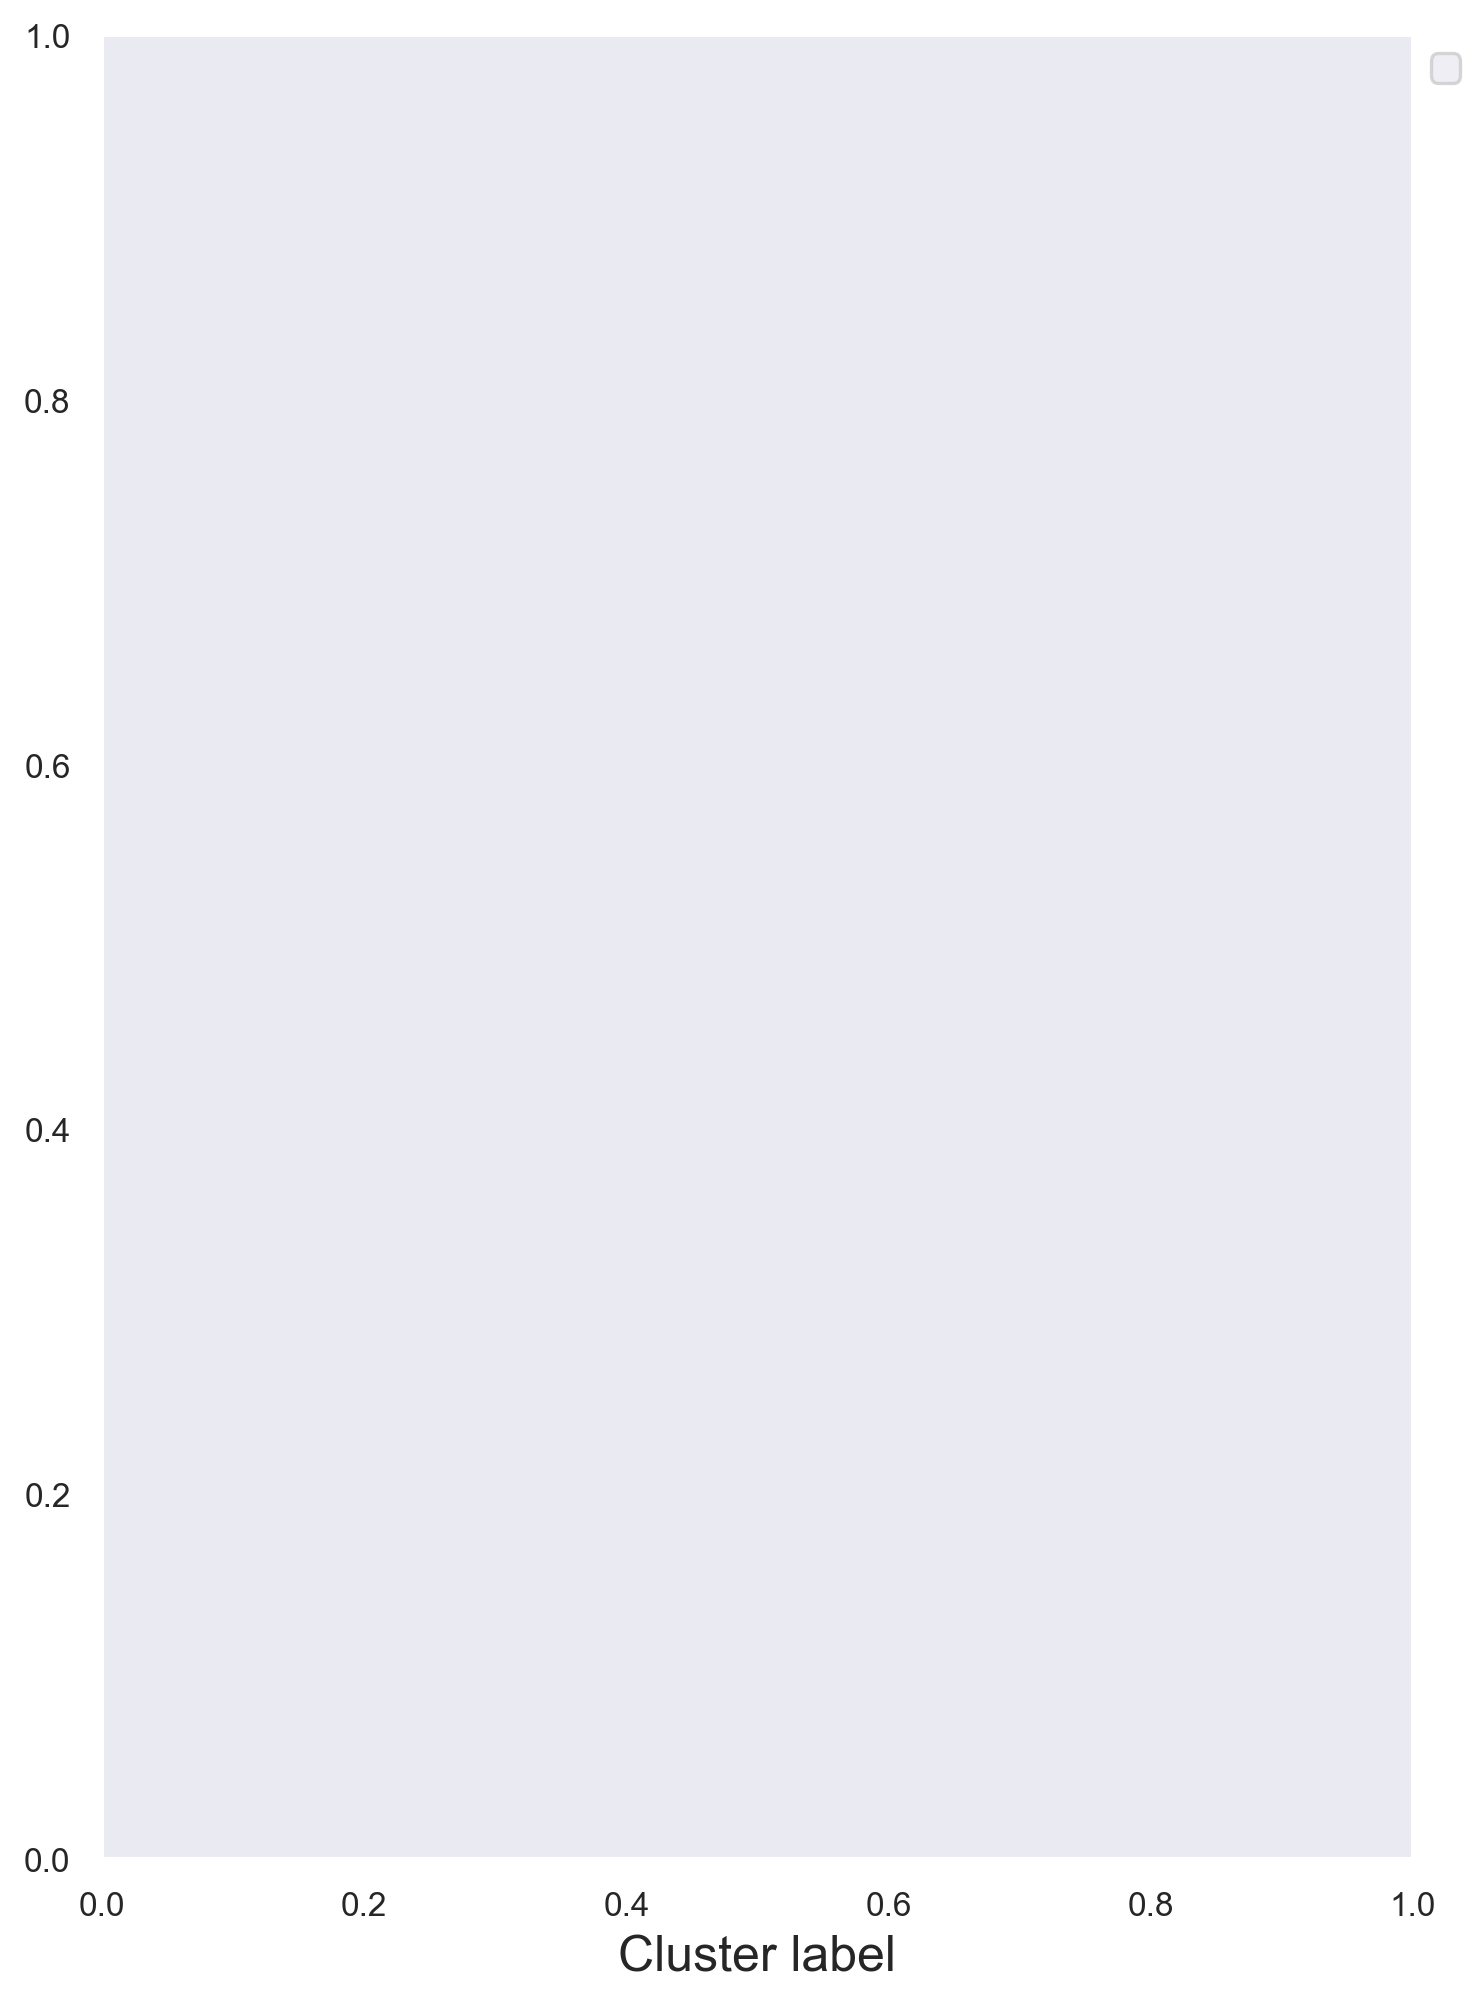

In [148]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

## KEGG_2021_Human

In [149]:
GeneCluster.enrich_geneclusters(gene_clust, 'KEGG_2021_Human')

In [150]:
enrich_res = pd.concat([gc.enrichment_res['KEGG_2021_Human'] for gc in gene_clust])
enrich_res = enrich_res.set_index(['Term'])
enrich_res.head()

,Rank,p-val,Z-score,Combined score,Overlapping genes,Adjusted P-value,Old p-value,Old adjusted p-value,num_overlap_genes,neg_log10(p_adj),cluster_label
Term,,,,,,,,,,,
Sphingolipid signaling pathway,1,0.000788,19.718519,140.914570,"[CERS5, PPP2R5A, FYN]",0.027572,0,0,3,1.559533,0
Sulfur metabolism,2,0.019336,67.062500,264.613326,[ETHE1],0.292289,0,0,1,0.534187,0
Viral myocarditis,3,0.049536,22.320833,67.075464,[FYN],0.292289,0,0,1,0.534187,0
Sphingolipid metabolism,4,0.056946,19.125000,54.805581,[CERS5],0.292289,0,0,1,0.534187,0
Drug metabolism,5,0.075232,14.078947,36.424788,[RRM1],0.292289,0,0,1,0.534187,0


In [151]:
terms = enrich_res[(enrich_res['Adjusted P-value'] < 0.05)].index.unique()
terms.size

2

In [152]:
from pandas.api.types import CategoricalDtype
enrich_res_plot = enrich_res.loc[terms].copy()
cat_type = CategoricalDtype(categories=['No significance', 'p < 0.05', 'p < 0.01', 'p < 0.001'], ordered=True)
enrich_res_plot['p-value'] = enrich_res_plot['Adjusted P-value'].apply(p_val_group).astype(cat_type)
enrich_results.append(enrich_res_plot)

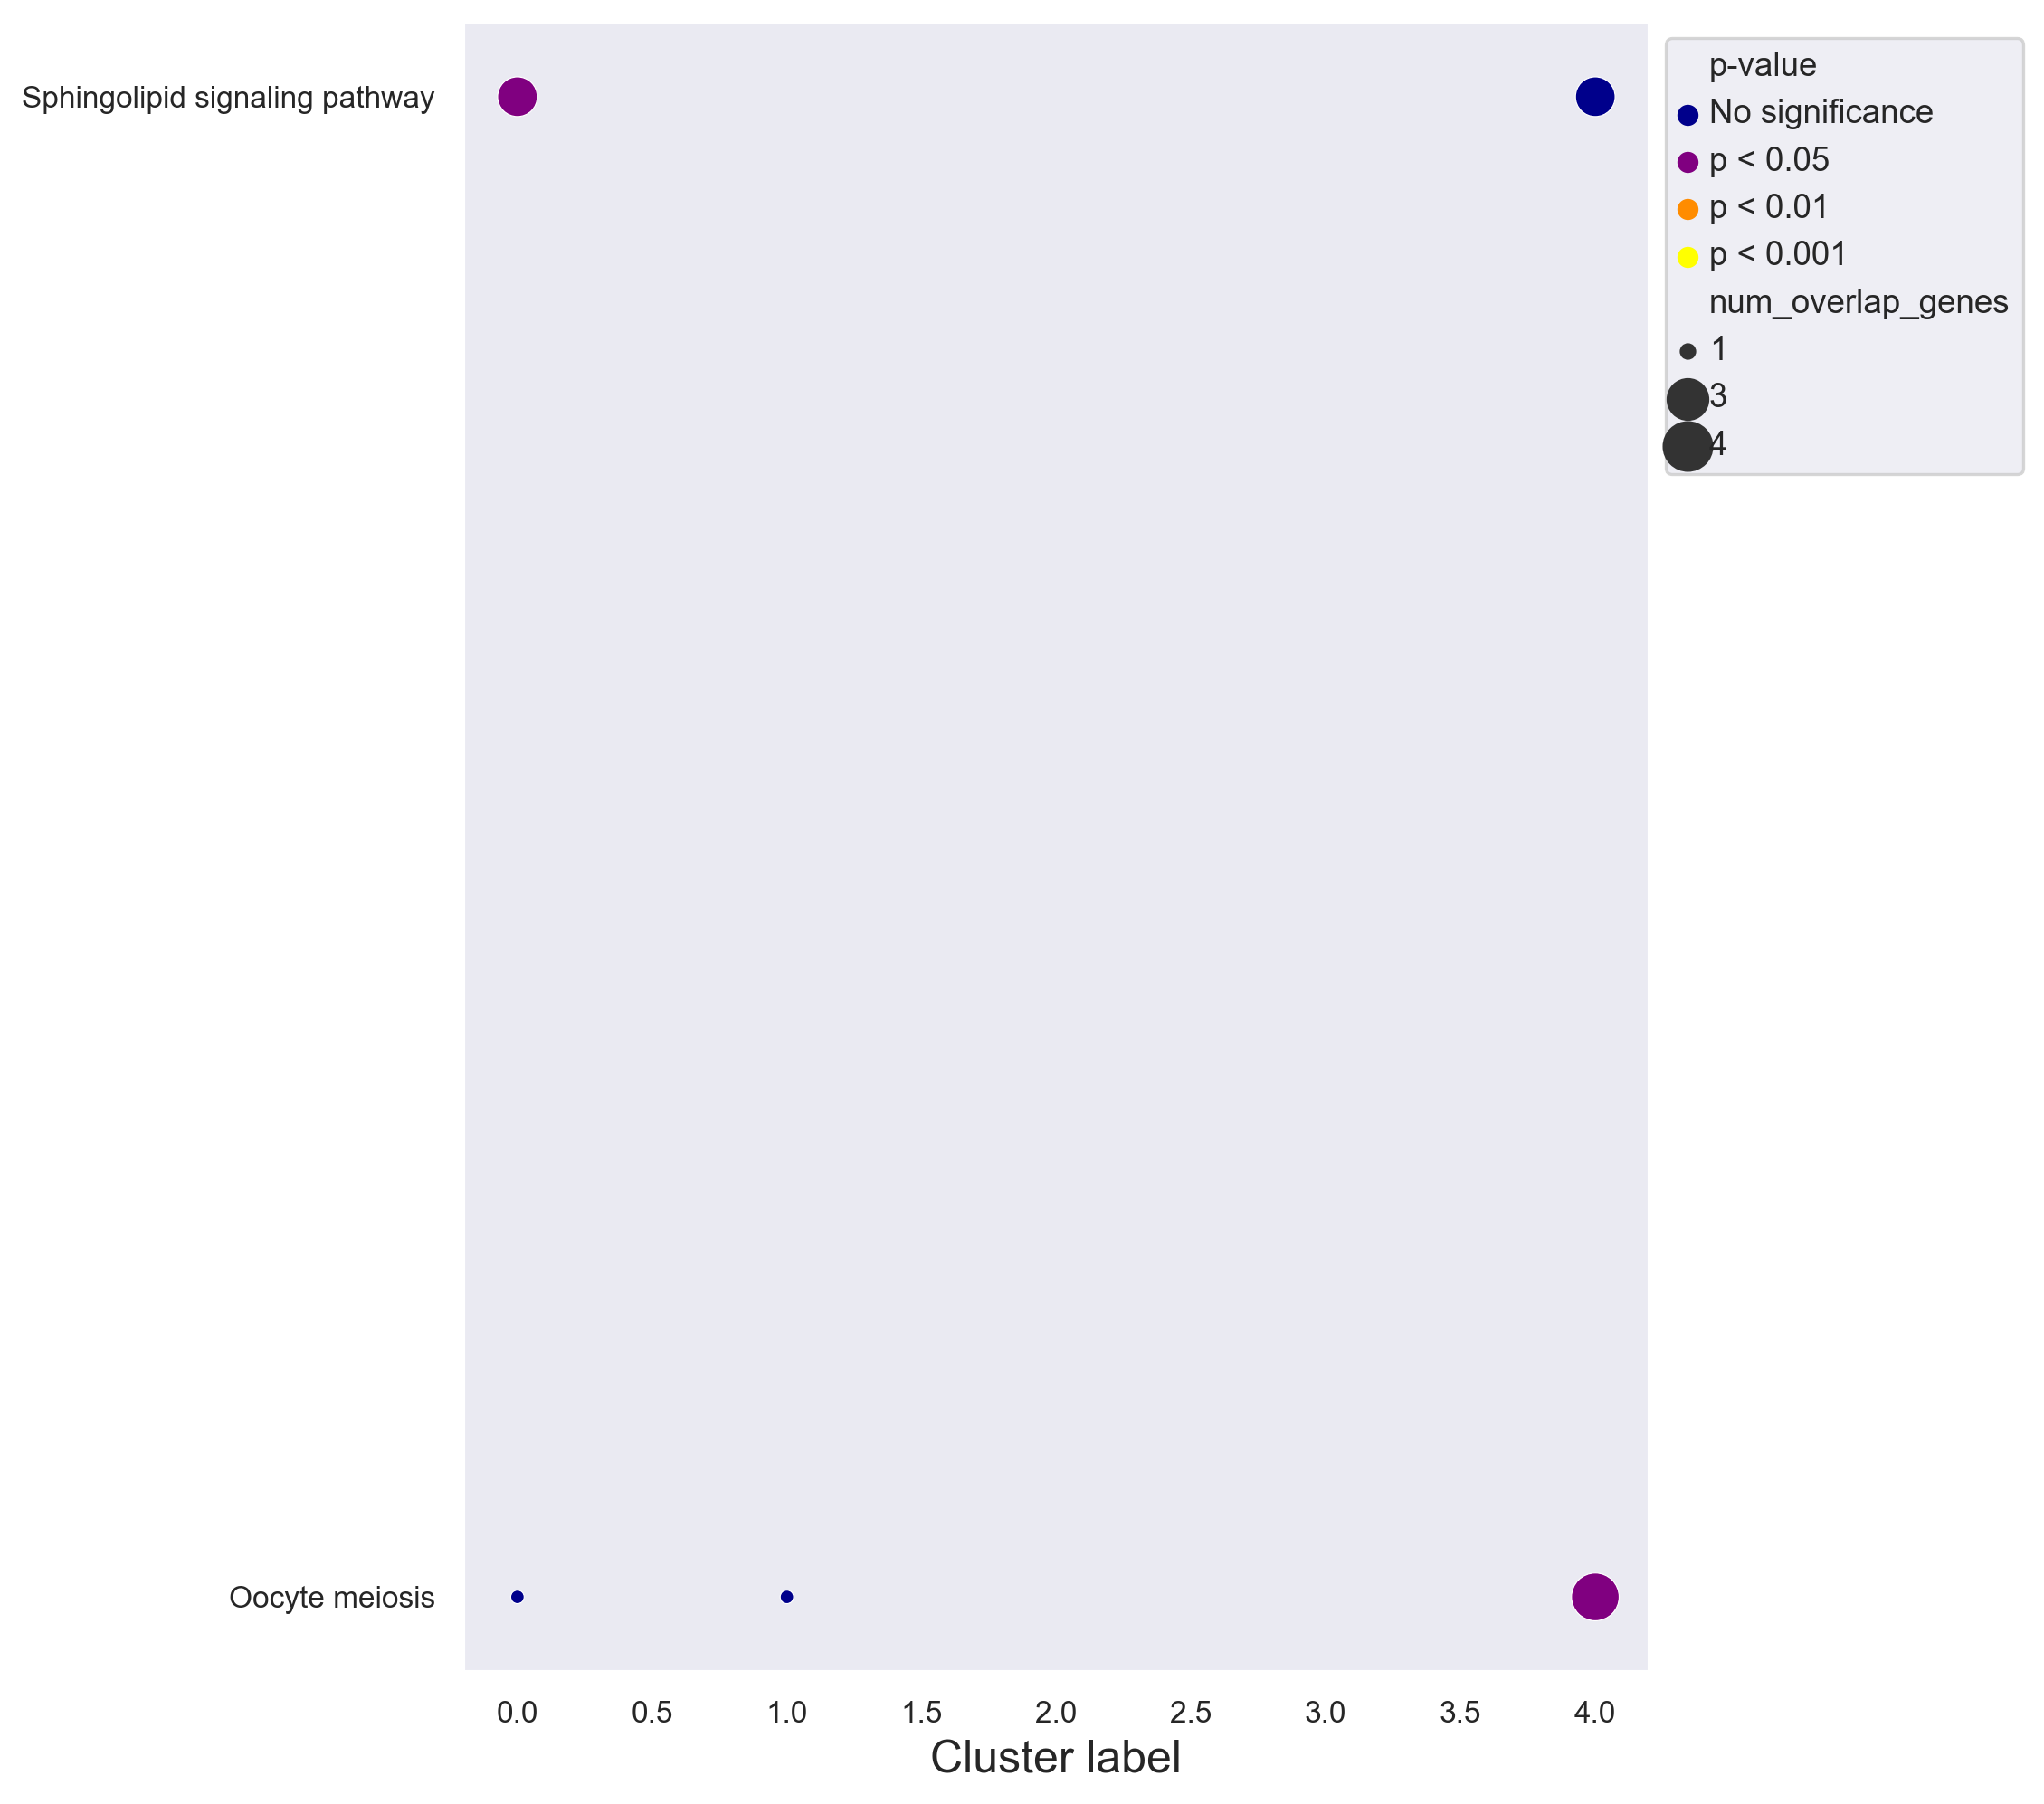

In [153]:
fig = plt.figure(figsize=(7, 10), dpi=120)

ax = sns.scatterplot(
    data=enrich_res_plot.reset_index(),
    x='cluster_label',
    y='Term',
    size='num_overlap_genes',
    sizes=(20, 250),
    hue='p-value',
    palette=color_discrete_map
)

ax.tick_params(labelsize=10)
ax.legend(fontsize=15)
ax.set_xlabel("Cluster label",fontsize=15)
ax.set_ylabel("", fontsize=10)
ax.grid(False)

sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))